# Data cleaning and merging replicate samples 

**Date**: written 2021-04-19  
**Author**: Katarina Braun 


## Overview
- Clean up the VCFs that Sniffles spits out 
- Drop any iSNVs not found in both replicates
- Average the frequency of the iSNVs found in these replicates and report this as 'FREQ'
- Drop any iSNVS <1% frequency 
- Make a "TV plot" figure to show comparison of SNVs and indels in replicate 1 and 2 


### a note about numbering schemes 

For H7N9, I used H7 numbering. This numbering scheme matches the numbering scheme on Nextstrain (https://nextstrain.org/).  
For H1N1pdm, I use H1 numbering. Again, this numbering scheme matches the numbering scheme on Nextstrain. For clarity, I start counting amino acids at nucleotide #51, AA #18 (D). 
 

## Input: 

- annotated VCF files that Sniffles outputs: `H7N9/data_derived/iSNVs/*`
 
## Output: 

1. Cleaned VCF files 
2. Cleaned VCF files averaged by replicate
3. Intersection plots: replicate 1 vs replicate 2 iSNVs
4. Counts for total iSNVs for CA04, GD3, rGD3, and Anhui. 


### import modules and dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import glob
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import splitext
from functools import reduce
from pandas.api.types import is_numeric_dtype
import warnings
from pandas.core.common import SettingWithCopyWarning
from matplotlib.font_manager import FontProperties 
from matplotlib import cm
import itertools
from matplotlib import container
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib as mpl
from pandas.plotting import table
import seaborn as sns
from scipy import stats


from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

## data cleaning

### define functions for data cleaning

In [2]:
# load all text files in a directory into Pandas dataframes 
def load_dataframes(path):
    filelist = [os.path.splitext(file)[0] for file in os.listdir(path) if file.endswith('.annotated_vcf')]
    list_of_DFs = []
    for file in filelist: 
        DF = path + '/' + file + '.annotated_vcf'
        file = pd.read_csv(DF, header=0, sep='\t', low_memory=False)
        list_of_DFs.append(file)
    print(filelist)
    return(list_of_DFs)

# clean up the iSNV dataframes
def clean_dataframes(path, list_of_DFs):
    for DF in list_of_DFs:
        sample = DF.columns[9]
        DF2 = DF.drop(['#CHROM', 'ID', 'QUAL', 'FILTER', 'FORMAT'], axis=1)
        DF1 = DF['INFO'].str.split('|', expand=True)
        DF3 = pd.concat([DF1, DF2], axis=1, join='inner')
        DF3[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']] = DF3[sample].str.split(':', expand=True)
        DF = DF3[['POS', 'REF', 'ALT', 'gene', 'AAchange', 'G', 'D']]
        DF = DF.rename(columns={3: 'gene', 'G': 'FREQ', 'AAchange':'annotation', 'D': 'read_depth'})
        DF['annotation'].replace(regex=True, inplace=True, to_replace=r'\.', value='syn')
        DF['FREQ'].replace(regex=True, inplace=True, to_replace=r'%', value='')
        DF['FREQ'] = pd.to_numeric(DF['FREQ'])
        DF['FREQ'] = DF['FREQ']/100
        DF['gene'] = DF['gene'].str.replace('NA gene','NA')
        DF = DF[~DF.annotation.str.contains("not in ORF")]
        DF['POS'] = DF['POS'].astype(str)
        DF['SNP'] = DF['gene'] + '_' + DF['REF'] + DF['POS'] + DF['ALT'] + '_' + DF['annotation']
        DF.to_csv(path + '/' + sample + '-cleaned.csv', sep='\t')
#

### VCF file data-cleaning

In [3]:
# generate a list of dataframes, loaded from Illumina VCF files 
list_of_DFs = load_dataframes('../data_derived/iSNVs')

print(len(list_of_DFs)) # this is the total number of samples we have, counting replicates 

['Anhui_ferret25_day1_rep1', 'Anhui_ferret25_day1_rep2', 'Anhui_ferret25_day3_rep1', 'Anhui_ferret25_day3_rep2', 'Anhui_ferret25_day5_rep1', 'Anhui_ferret25_day5_rep2', 'Anhui_ferret25_day7_rep1', 'Anhui_ferret25_day7_rep2', 'Anhui_ferret27_day1_rep1', 'Anhui_ferret27_day1_rep2', 'Anhui_ferret27_day3_rep2', 'Anhui_ferret27_day3_rep1', 'Anhui_ferret27_day5_rep1', 'Anhui_ferret27_day5_rep2', 'Anhui_ferret27_day7_rep1', 'Anhui_ferret27_day7_rep2', 'Anhui_ferret28_day3_rep1', 'Anhui_ferret28_day3_rep2', 'Anhui_ferret28_day5_rep1', 'Anhui_ferret28_day5_rep2', 'Anhui_ferret28_day7_rep1', 'Anhui_ferret28_day7_rep2', 'Anhui_ferret29_day1_rep1', 'Anhui_ferret29_day1_rep2', 'Anhui_ferret29_day3_rep1', 'Anhui_ferret29_day3_rep2', 'Anhui_ferret29_day5_rep1', 'Anhui_ferret29_day5_rep2', 'Anhui_ferret29_day7_rep1', 'Anhui_ferret29_day7_rep2', 'Anhui_ferret31_day1_rep2', 'Anhui_ferret31_day1_rep1', 'Anhui_ferret31_day3_rep2', 'Anhui_ferret31_day3_rep1', 'Anhui_ferret31_day5_rep1', 'Anhui_ferret31_day

In [4]:
%%bash 


# remove all files (if there are any) in the `vcf-cleaned` directory 

rm ../data_derived/vcfs-cleaned/*.csv

In [5]:
# clean up all of the dataframes and save to new CSV files 
clean_dataframes('../data_derived/vcfs-cleaned', list_of_DFs)

# function to find intersection SNVs

In [6]:
def find_intersection_all(path, df_list):
    # create list of unique dataframe identifiers – this enables easy pairing of csvs
    value_list=[]
    value_set=[]
    for item in df_list:
        if "rep1" in item:
            value = item.replace("rep1-cleaned.csv","")
        if "rep2" in item:
            value = item.replace("rep2-cleaned.csv","")
            value_list.append(value)
#             print(value_list)
        value_set=set(value_list)   
#             print(value_list)
    for item in value_set:
        # create dataframes from csv files
        rep1_path = path + item + 'rep1-cleaned.csv'
        rep1_df = pd.read_csv(rep1_path, sep='\t')
        rep2_path = path + item + 'rep2-cleaned.csv'
        rep2_df = pd.read_csv(rep2_path, sep='\t')
        # clean up column names
        rep1_df = rep1_df.rename(columns={'FREQ': '%-rep1'})
        rep2_df = rep2_df.rename(columns={'FREQ': '%-rep2'})
        A1_1m = rep1_df[['SNP', '%-rep1', 'POS']]
        B1_1m = rep2_df[['SNP', '%-rep2', 'POS']]
        df1_1 = pd.merge(A1_1m, B1_1m, on='SNP', how='outer')
        df1_1['POS_x'] = df1_1['POS_x'].fillna(df1_1['POS_y'])
        df1_1 = df1_1[['SNP', 'POS_x', '%-rep1', '%-rep2']]
        df1_1 = df1_1.sort_values('POS_x', ascending=True)
        df1_1['FREQ'] = df1_1[['%-rep1', '%-rep2']].mean(axis=1)
        df1_1 = df1_1.rename(columns={'%-rep1': 'rep1_percent', '%-rep2': 'rep2_percent'})
        df1_1.loc[df1_1.FREQ >= 0.99, 'FREQ'] = 1.0 # any SNVs average >0.97 FREQ are likely fixed so I'll rewrite anything >0.97 to 1.0
        df1_1 = df1_1.rename(columns={'FREQ': '%'})
#         df1_1 = df1_1.fillna(0)
        df1_1.to_csv('../data_derived/vcfs-all/'+ item + 'intersection.csv', sep='\t')
    
    #

In [7]:
def find_intersection_intersection(path, df_list):
    # create list of unique dataframe identifiers – this enables easy pairing of csvs
    value_list=[]
    value_set=[]
    for item in df_list:
        if "rep1" in item:
            value = item.replace("rep1-cleaned.csv","")
        if "rep2" in item:
            value = item.replace("rep2-cleaned.csv","")
            value_list.append(value)
#             print(value_list)
        value_set=set(value_list)   
#             print(value_list)
    for item in value_set:
        # create dataframes from csv files
        rep1_path = path + item + 'rep1-cleaned.csv'
        rep1_df = pd.read_csv(rep1_path, sep='\t')
        rep2_path = path + item + 'rep2-cleaned.csv'
        rep2_df = pd.read_csv(rep2_path, sep='\t')
        # clean up column names
        rep1_df = rep1_df.rename(columns={'FREQ': '%-rep1'})
        rep2_df = rep2_df.rename(columns={'FREQ': '%-rep2'})
        A1_1m = rep1_df[['SNP', '%-rep1', 'POS']]
        B1_1m = rep2_df[['SNP', '%-rep2', 'POS']]
        df1_1 = pd.merge(A1_1m, B1_1m, on='SNP', how='outer')
        df1_1['POS_x'] = df1_1['POS_x'].fillna(df1_1['POS_y'])
        df1_1 = df1_1[['SNP', 'POS_x', '%-rep1', '%-rep2']]
        df1_1 = df1_1.sort_values('POS_x', ascending=True)
        df1_1['FREQ'] = df1_1[['%-rep1', '%-rep2']].mean(axis=1)
        df1_1 = df1_1.rename(columns={'%-rep1': 'rep1_percent', '%-rep2': 'rep2_percent'})
        df1_1.loc[df1_1.FREQ >= 0.99, 'FREQ'] = 1.0 # any SNVs average >0.97 FREQ are likely fixed so I'll rewrite anything >0.97 to 1.0
        df1_1 = df1_1.rename(columns={'FREQ': '%'})
        df1_1_intersection = df1_1.dropna()
#         print(df1_1_intersection)
        df1_1_intersection.to_csv('../data_derived/vcfs-intersection/'+ item + 'intersection.csv', sep='\t')
    
    #

In [8]:
%%bash

# remove all files (if there are any) in the `vcf-all` directory 

rm ../data_derived/vcfs-all/*.csv # keeps only variants that are found in both reps
rm ../data_derived/vcfs-intersection/*.csv # keeps all variants (regardless of whether they are found in both reps)

In [9]:
# make a list of the cleaned CSV files 

directory = '../data_derived/vcfs-cleaned/'
files_dir =  os.listdir(directory)
newlist = []
for names in files_dir:
    if names.endswith(".csv"):
        newlist.append(names)
# print(newlist)

In [10]:
find_intersection_all('../data_derived/vcfs-cleaned/', newlist)
find_intersection_intersection('../data_derived/vcfs-cleaned/', newlist)

In [11]:
# load all text files in a directory into Pandas dataframes 
def load_intersection_dataframes(path):
    filelist = [os.path.splitext(file)[0] for file in os.listdir(path) if file.endswith('_intersection.csv')]
    list_of_DFs = []
    for file in filelist:
        DF = path + '/' + file + '.csv'
        file = pd.read_csv(DF, header=0, sep='\t', low_memory=False)
        list_of_DFs.append(file)
#     print(filelist)
    return(list_of_DFs)

# generate a list of intersection dataframes
list_of_intersection_DFs = load_intersection_dataframes('../data_derived/vcfs-intersection')

print(len(list_of_intersection_DFs)) # this is the total number of samples

106


# Plot variant frequencies between replicate 1 and 2

In [12]:
# load all intersection files in a directory into Pandas dataframes 
def load_intersection_dataframes(path):
    filelist = [os.path.splitext(file)[0] for file in os.listdir(path) if file.endswith('_intersection.csv')]
    list_of_DFs = []
    list_of_DF_names = []
    for file in filelist: 
        fullname = path + '/' + file + '.csv'
        DF = pd.read_csv(fullname, header=0, sep='\t', low_memory=False)
        DF.name = file 
        list_of_DF_names.append(file)
        list_of_DFs.append(DF)
#     print(list_of_DF_names)
    return(list_of_DFs)

def plot_intersection(intersection_list):
    for DF in intersection_list: 
        # global settings 
        fig1 = plt.figure(figsize=(8,8), facecolor='w')
        plt.style.use('default')
        mpl.rc('font', family='Arial')
        gs = gridspec.GridSpec(2,8)
        # define subplots
        ax1 = fig1.add_subplot(gs[0,0:4], aspect='equal') # replicate plot
        ax2 = fig1.add_subplot(gs[0,4:8], aspect='equal') # replicate plot ZOOM
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['bottom'].set_visible(True)
        ax1.spines['left'].set_visible(True)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_visible(True)
        ax2.spines['left'].set_visible(True)
        # set fontsize of axes 
        ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
        ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
        ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
        ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)
        sample = DF.name
        # FOR PLOT replicate plot
        ax1.scatter(DF.rep1_percent, DF.rep2_percent, color='#7C9BAC', alpha=0.8)
        ax2.scatter(DF.rep1_percent, DF.rep2_percent, color='#7C9BAC', alpha=0.8)
        # edit the axes - ax1
        ax1.set_title(sample, fontname='Arial', fontsize=14)
        ax1.set_ylabel('iSNV frequency replicate #2', fontname='Arial', fontsize=10)
        ax1.set_xlabel('iSNV frequency replicate #1', fontname='Arial', fontsize=10)
        ax1.set_facecolor('white')
        for tick in ax1.get_xticklabels():
            tick.set_fontname("Arial")
        for tick in ax1.get_yticklabels():
            tick.set_fontname("Arial")
        ax1.set_ylim(0.001,1.03)
        ax1.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
        ax1.set_xlim(0.001,1.03)
        ax1.set_xticks([0, 0.25, 0.50, 0.75, 1.0])
        # edit the axes - ax2
        ax2.set_title(sample + ' ZOOM', fontname='Arial', fontsize=14)
        ax2.set_ylabel('iSNV frequency (1-15%) replicate #2', fontname='Arial', fontsize=10)
        ax2.set_xlabel('iSNV frequency (1-15%) replicate #1', fontname='Arial', fontsize=10)
        ax2.set_facecolor('white')
        for tick in ax2.get_xticklabels():
            tick.set_fontname("Arial")
        for tick in ax2.get_yticklabels():
            tick.set_fontname("Arial")
        ax2.set_ylim(-0.001, 0.15)
        ax2.set_yticks([0.05, 0.1, 0.15])
        ax2.set_xlim(-0.001, 0.15)
        ax2.set_xticks([0.05, 0.1, 0.15])
        # use tight_layout to optimize spacing of axes and titles within each subplot
        fig1.tight_layout()
        # save this plot to the figures folder 
        fig1.savefig('../figures/intersection-plots/' + sample + '.pdf', bbox_inches='tight', dpi=300)

def r2(x, y):
    return stats.pearsonr(x, y)[0] **2
        
def plot_intersection_combined(intersection_list, concat_dataframe):
    # global settings 
    fig1 = plt.figure(figsize=(8,8), facecolor='w')
    plt.style.use('default')
    mpl.rc('font', family='Arial')
    gs = gridspec.GridSpec(2,10)
    
    # define subplots
    ax1 = fig1.add_subplot(gs[1,0:5], aspect='equal') # replicate plot
    ax2 = fig1.add_subplot(gs[1,5:10], aspect='equal') # replicate plot ZOOM
   
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['left'].set_visible(True)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(True)
    ax2.spines['left'].set_visible(True)
    
    # set fontsize of axes 
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
    ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
    ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

    # edit the axes - ax1
    ax1.set_ylabel('iSNV frequency replicate #2', fontname='Arial', fontsize=10)
    ax1.set_xlabel('iSNV frequency replicate #1', fontname='Arial', fontsize=10)
    for tick in ax1.get_xticklabels():
        tick.set_fontname("Arial")
    for tick in ax1.get_yticklabels():
        tick.set_fontname("Arial")
    ax1.set_ylim(0.001,1.03)
    ax1.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
    ax1.set_xlim(0.001,1.03)
    ax1.set_xticks([0, 0.25, 0.50, 0.75, 1.0])
    
    # edit the axes - ax2
    ax2.set_ylabel('iSNV frequency (1-15%) replicate #2', fontname='Arial', fontsize=10)
    ax2.set_xlabel('iSNV frequency (1-15%) replicate #1', fontname='Arial', fontsize=10)
    for tick in ax2.get_xticklabels():
        tick.set_fontname("Arial")
    for tick in ax2.get_yticklabels():
        tick.set_fontname("Arial")
    ax2.set_ylim(-0.001, 0.15)
    ax2.set_yticks([0.05, 0.1, 0.15])
    ax2.set_xlim(-0.001, 0.15)
    ax2.set_xticks([0.05, 0.1, 0.15])
    
    r2 = stats.pearsonr(concat_dataframe['rep1_percent'], concat_dataframe['rep2_percent'])
    p = sns.jointplot(data=concat_dataframe, x='rep1_percent', y='rep2_percent', kind="reg", ylim=(0,1), xlim=(0,1), color='grey')
    p.fig.text(0.85, 0.85, r2, fontsize=12)
    
    for DF in intersection_list: 
        ax1.scatter(DF.rep1_percent, DF.rep2_percent, color='#7C9BAC', alpha=0.8)
        ax2.scatter(DF.rep1_percent, DF.rep2_percent, color='#7C9BAC', alpha=0.8)
    
    fig1.tight_layout()
    # save this plot to the figures folder 
    fig1.savefig('../figures/intersection-plots/combined-intersection-plots.pdf', bbox_inches='tight', dpi=300)
    p.savefig('../figures/intersection-plots/combined-intersection-plots-with-frequency.pdf', bbox_inches='tight', dpi=300)

#

#

In [13]:
%%bash

# remove all files (if there are any) in the `vcf-all` directory 

rm ../figures/intersection-plots/*.pdf

/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


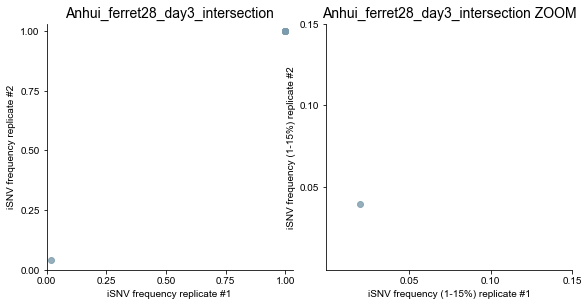

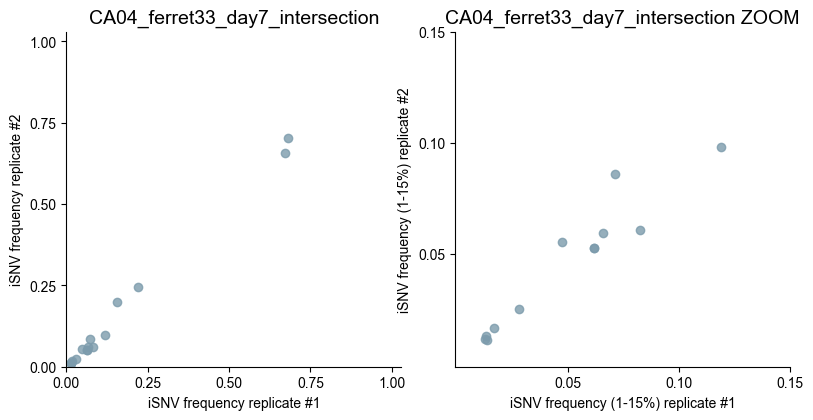

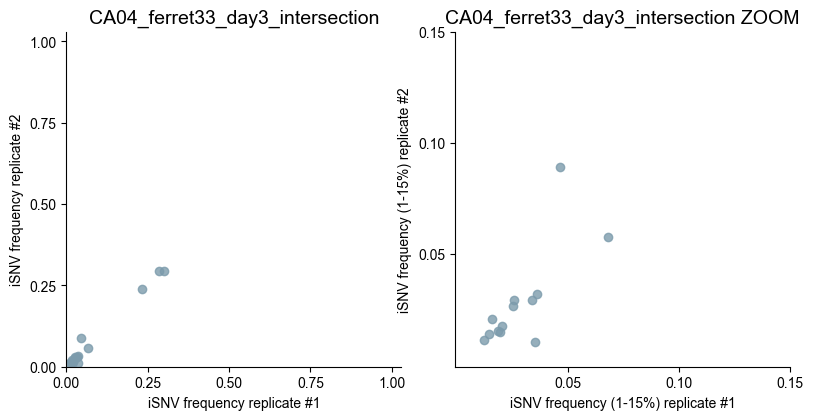

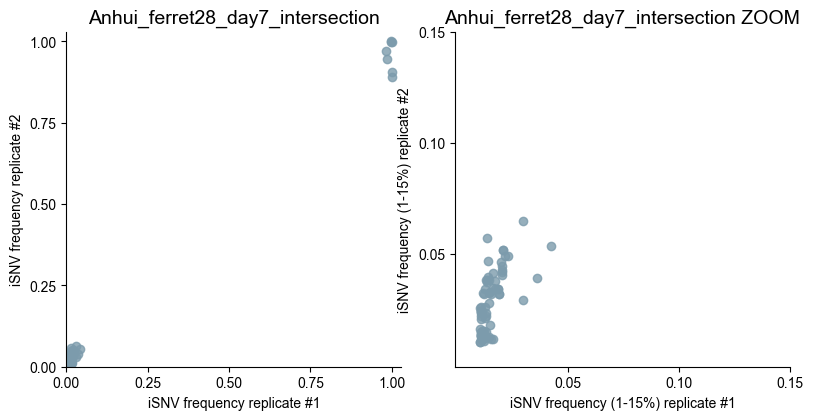

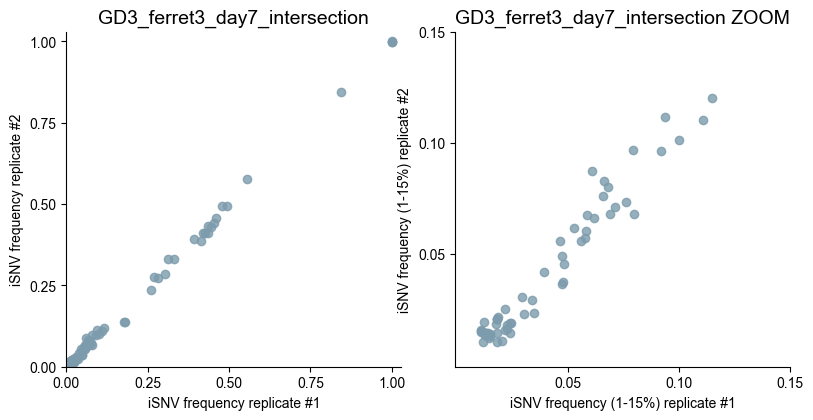

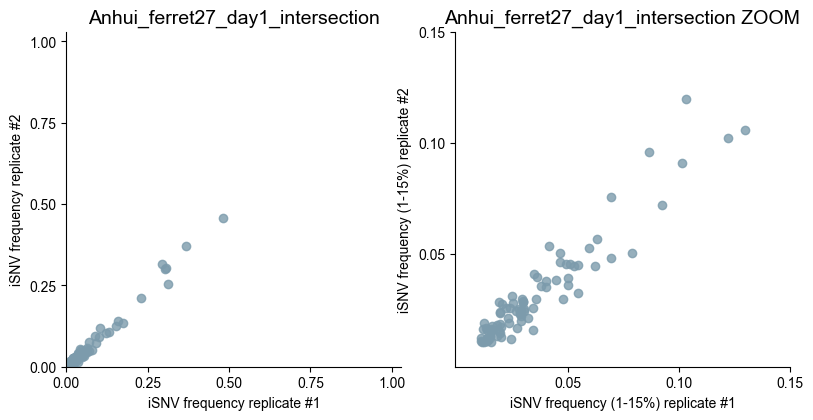

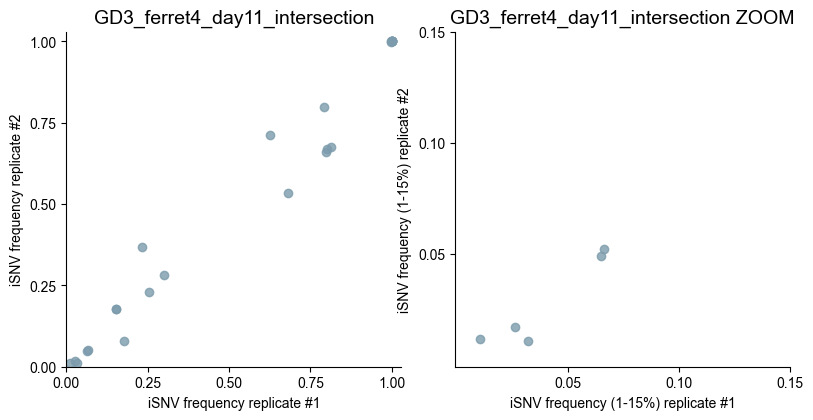

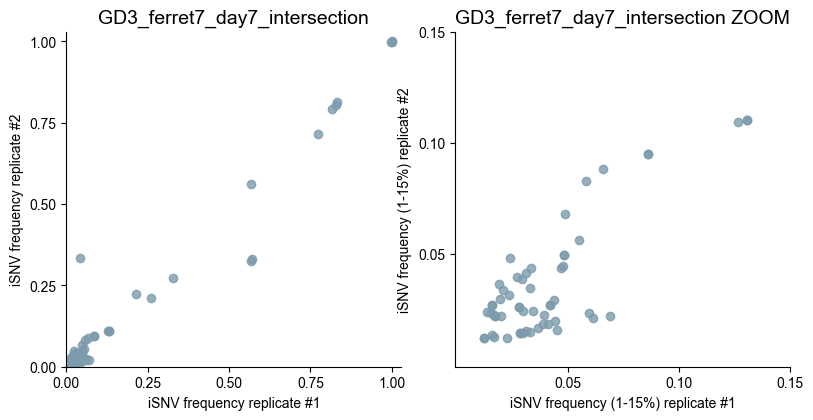

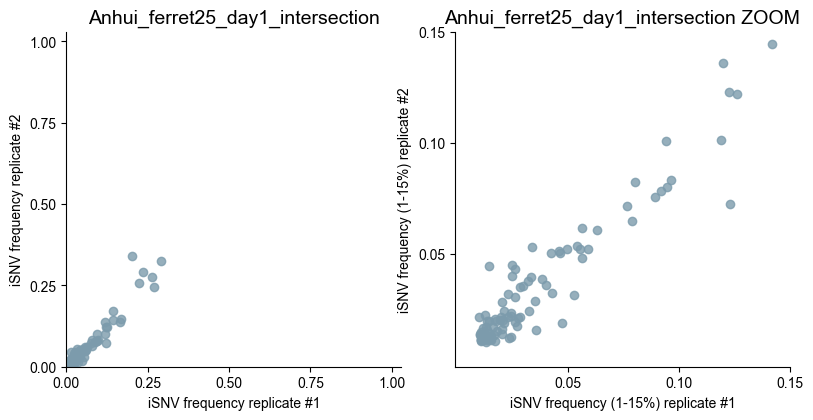

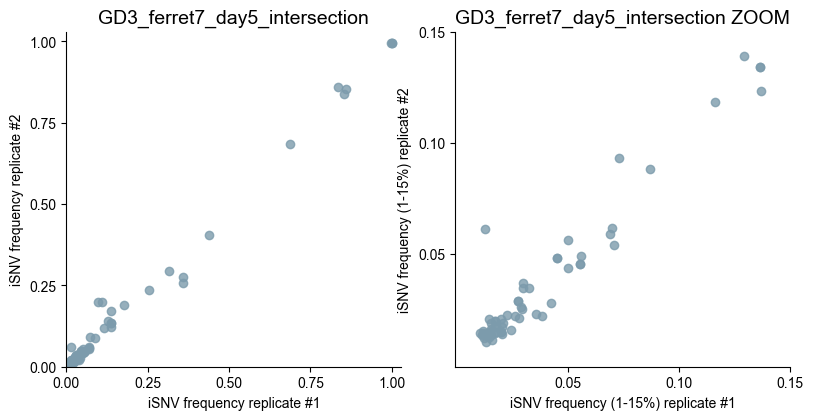

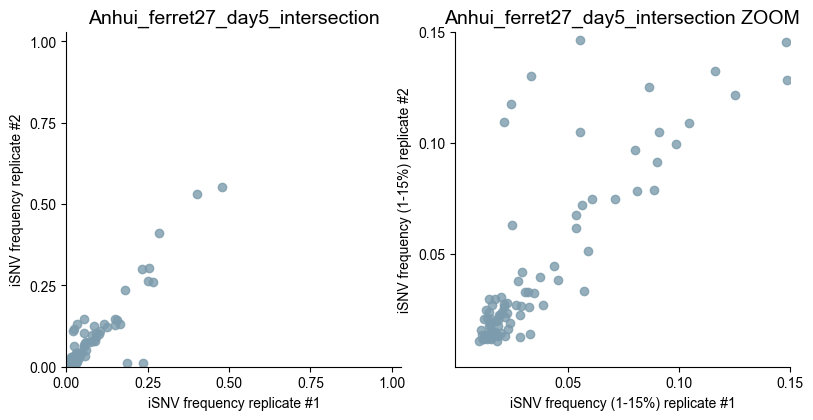

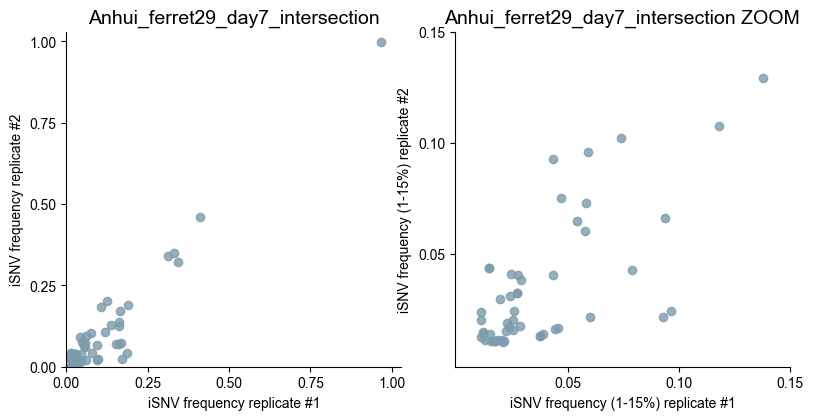

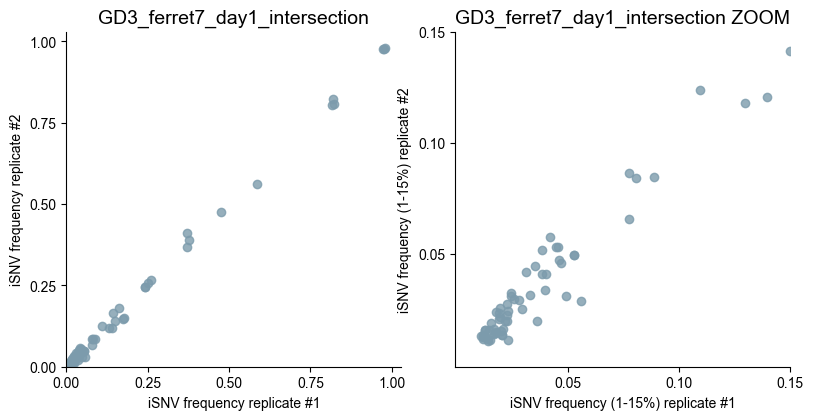

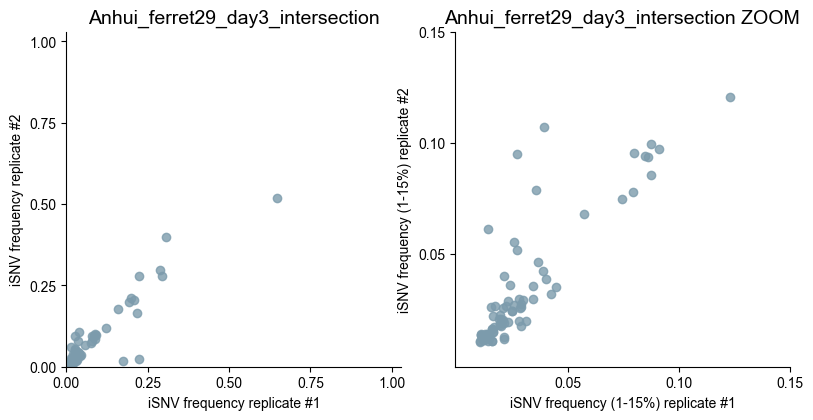

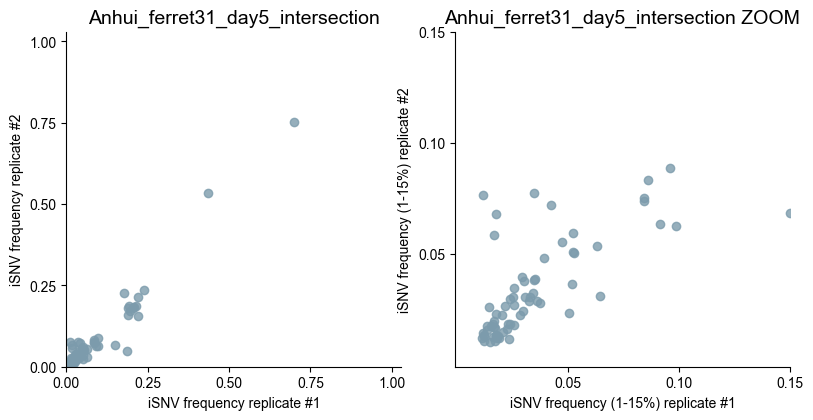

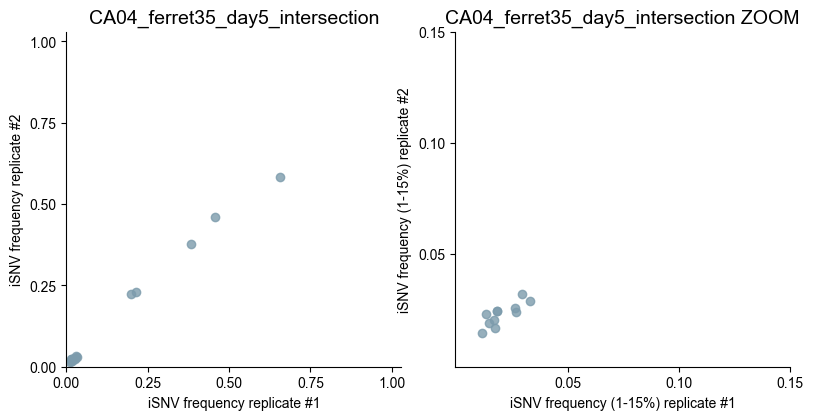

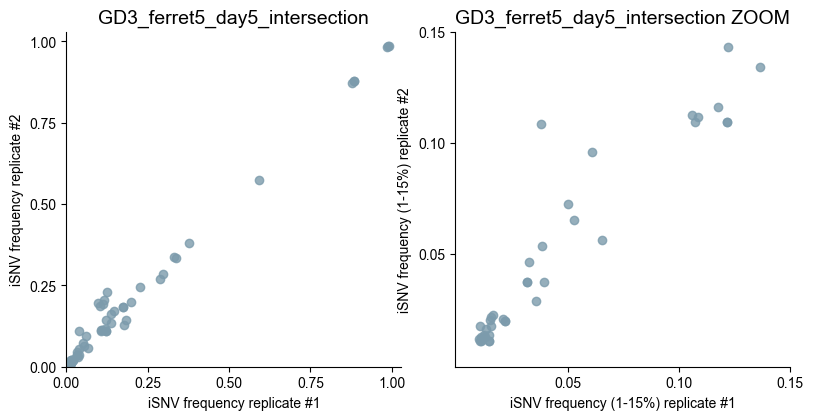

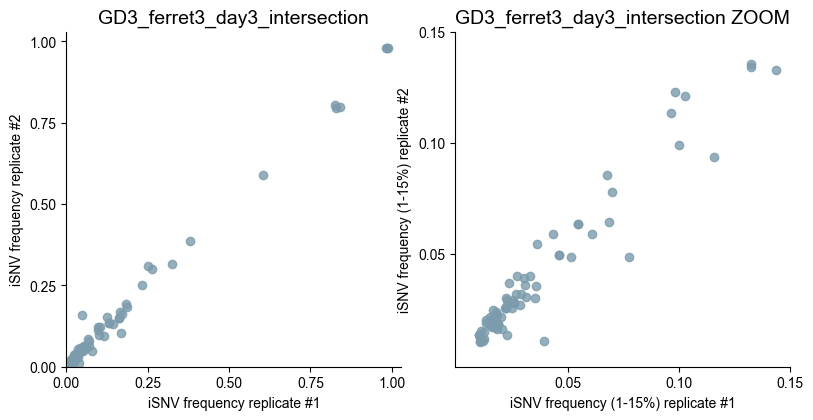

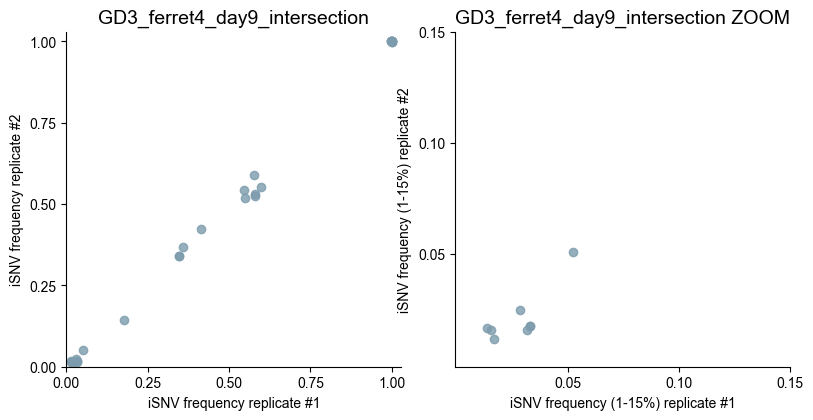

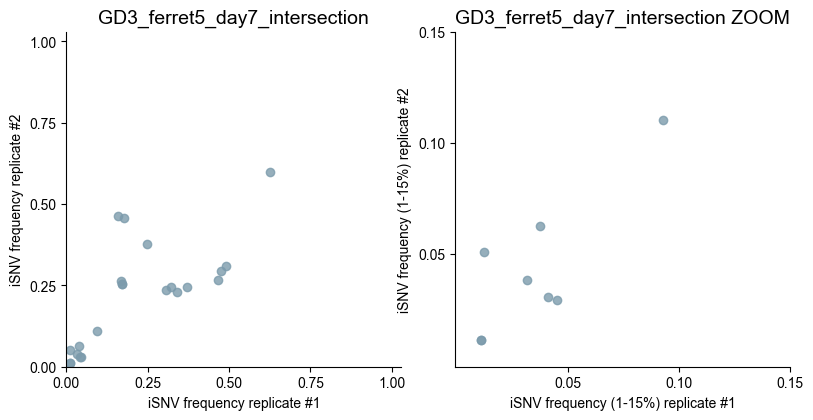

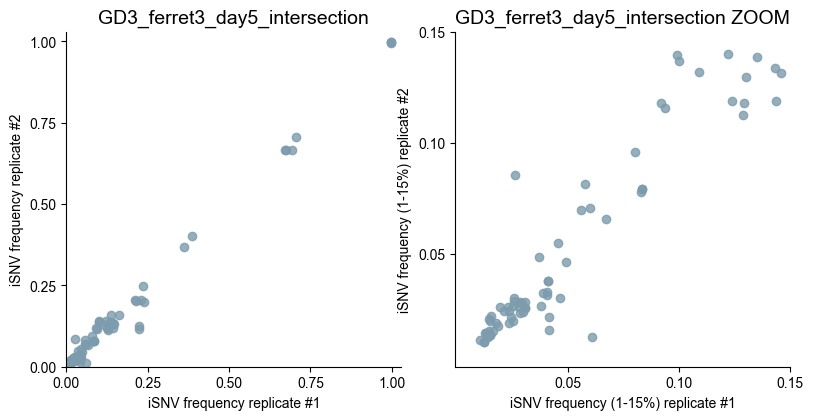

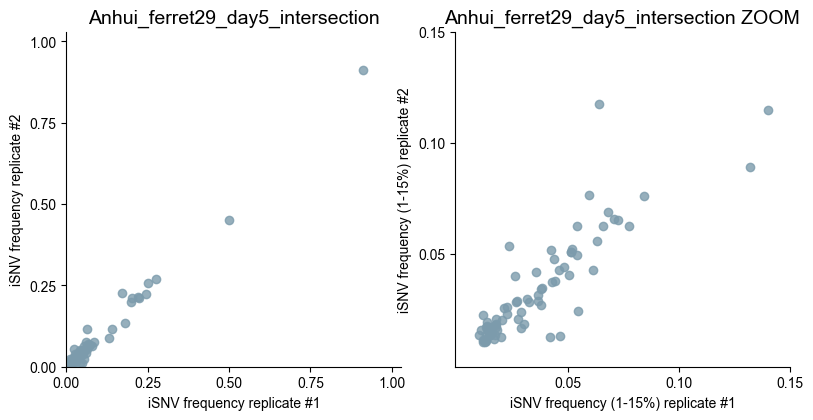

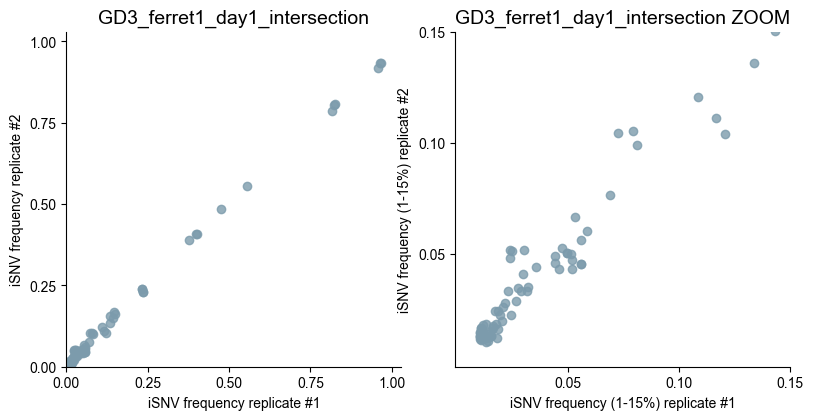

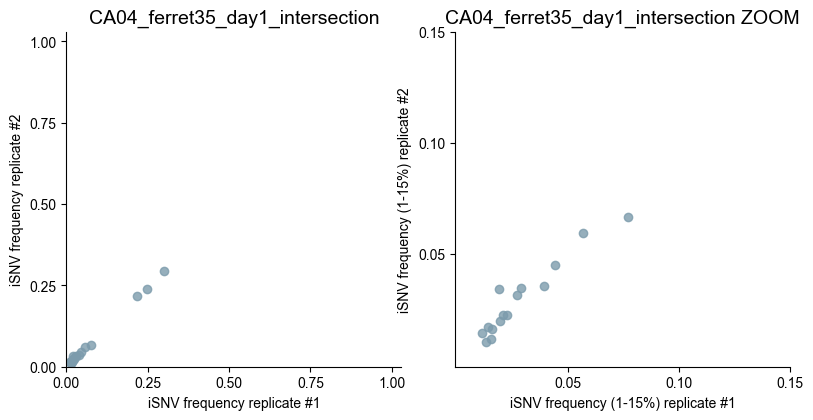

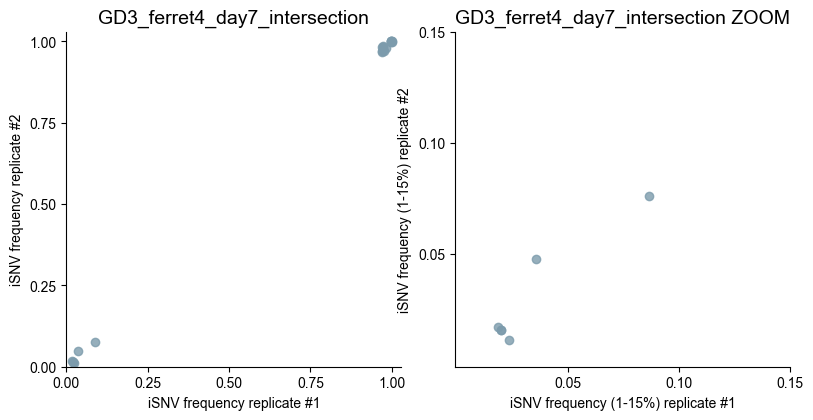

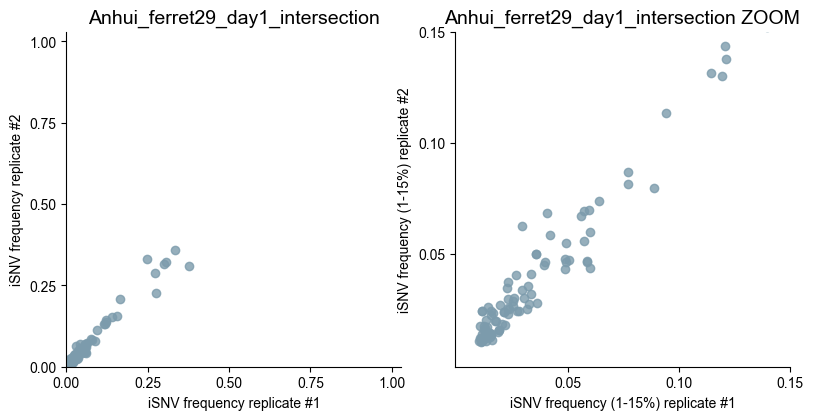

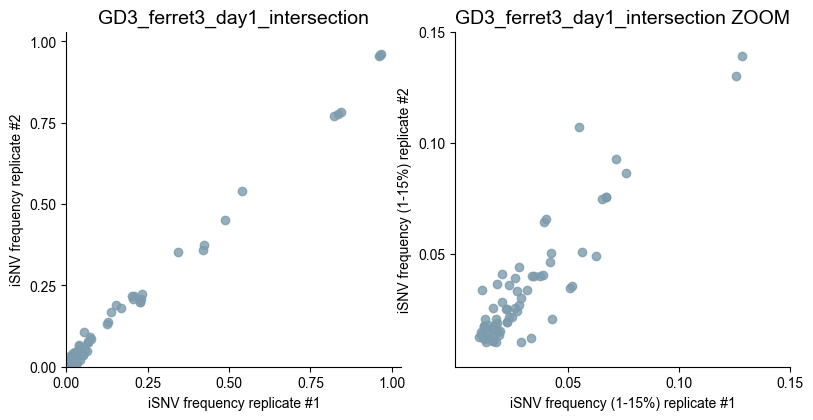

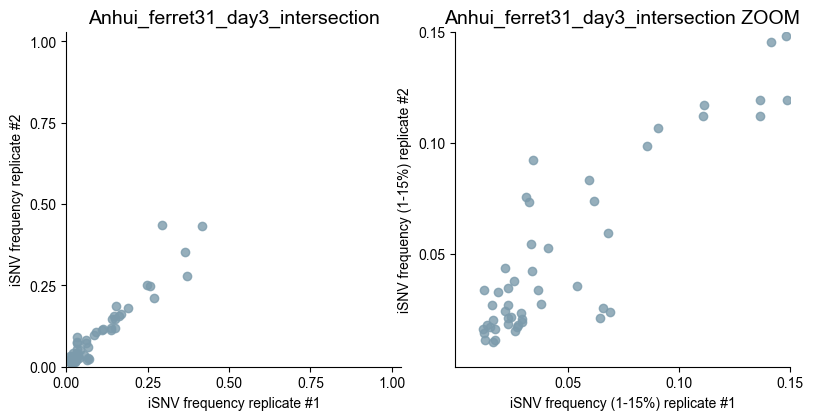

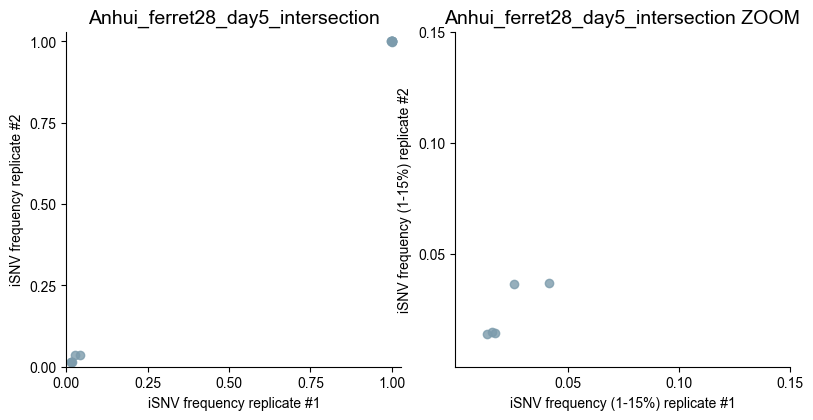

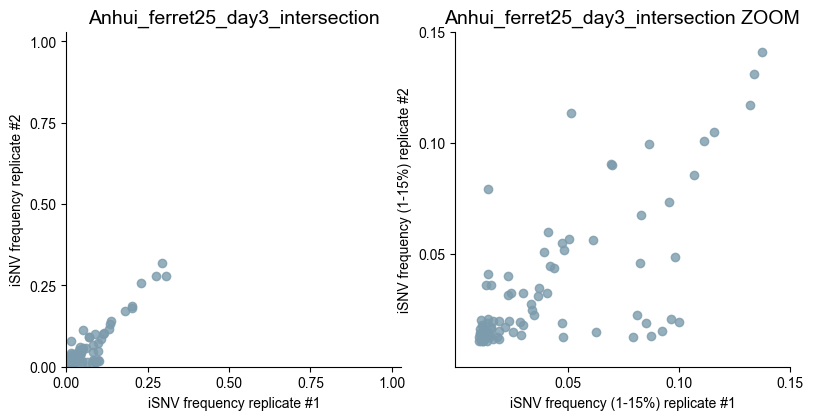

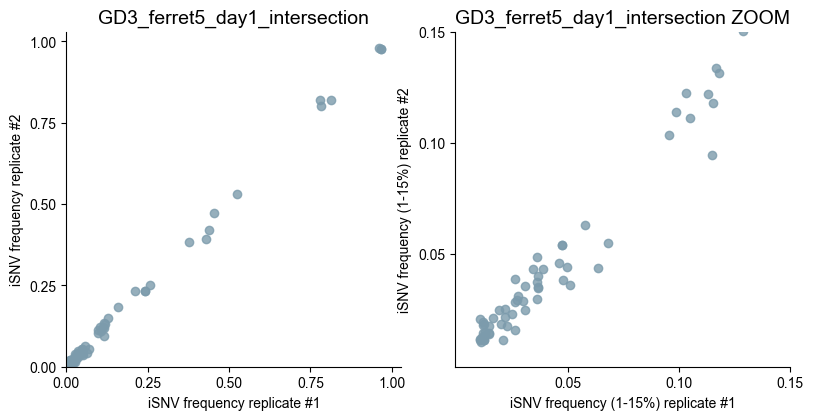

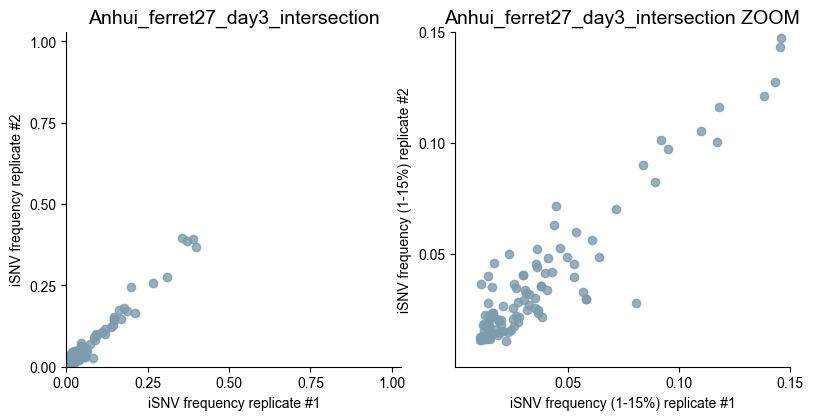

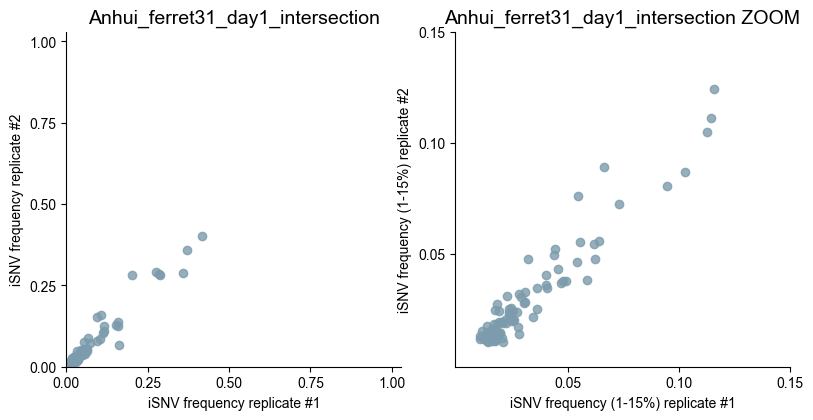

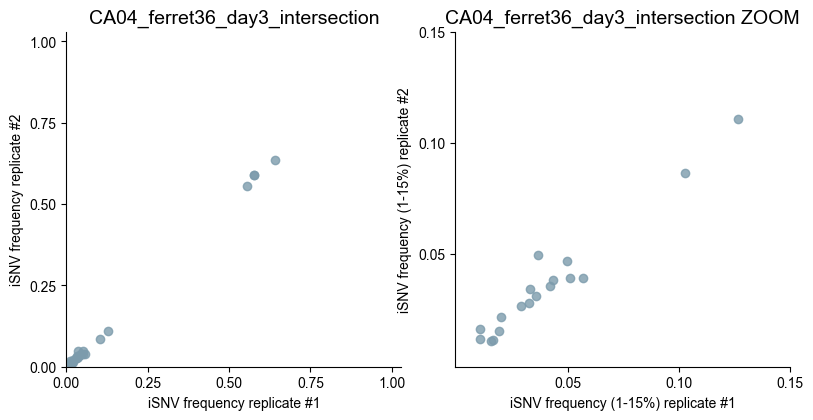

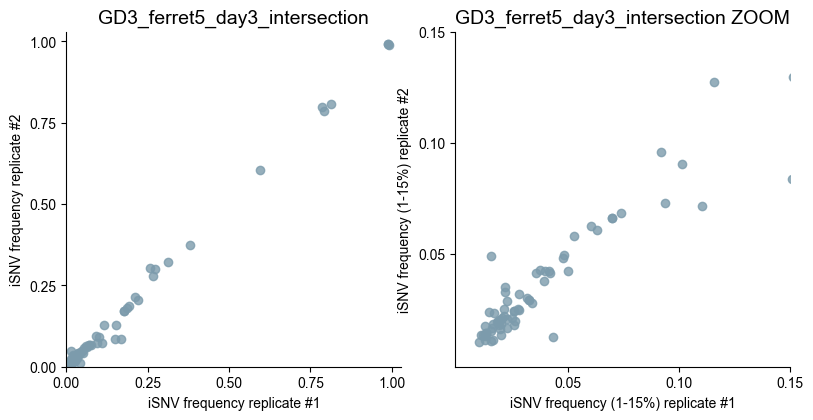

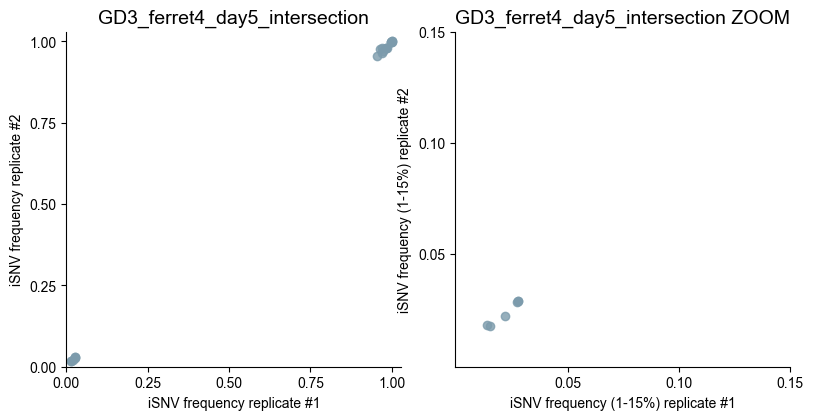

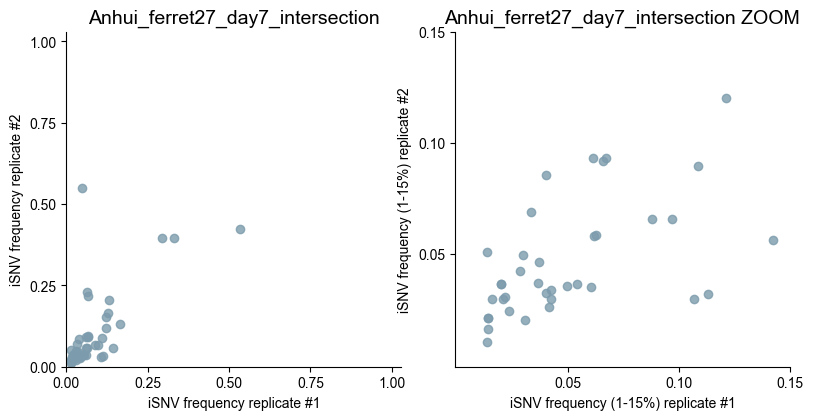

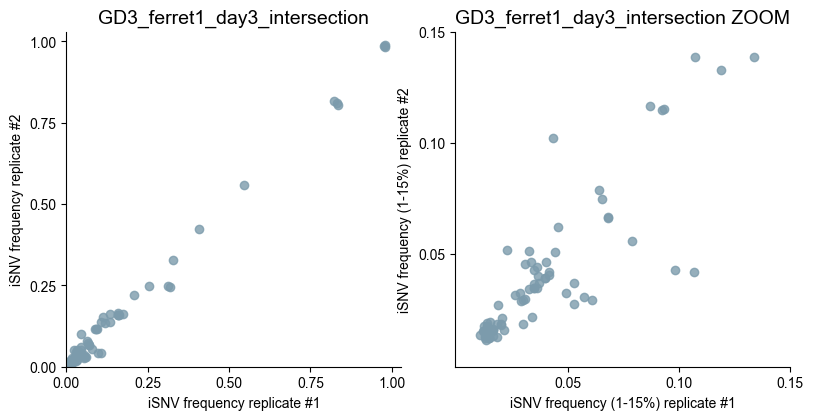

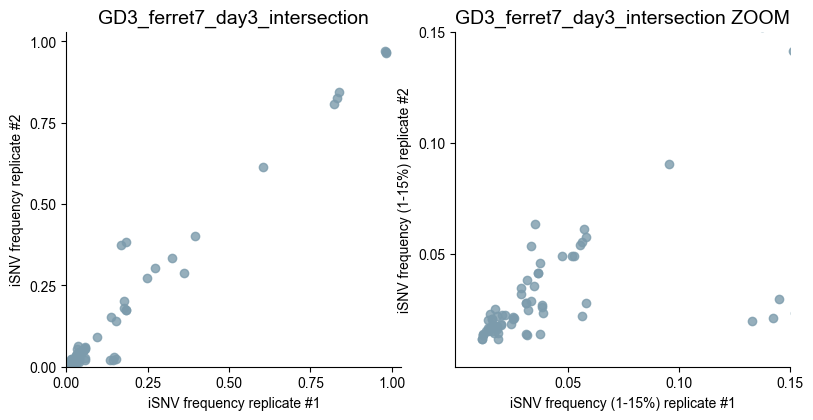

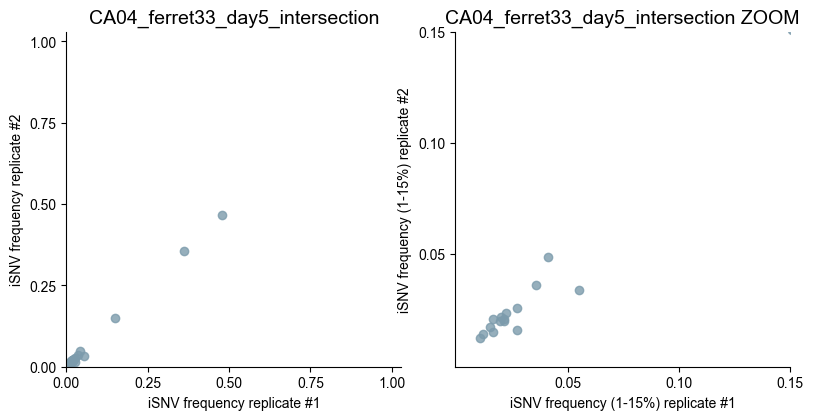

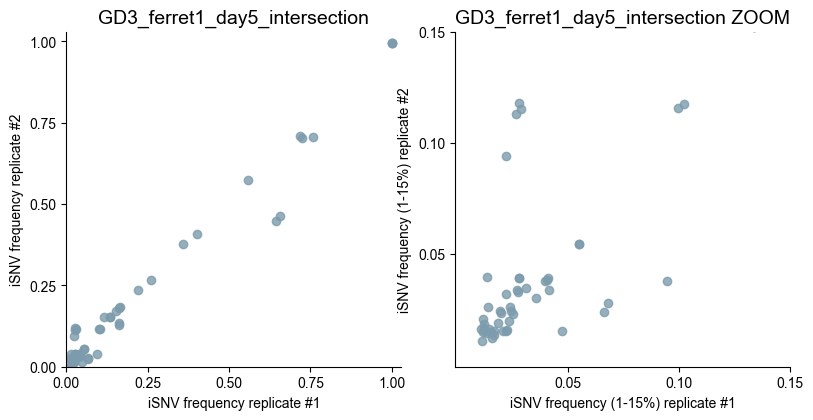

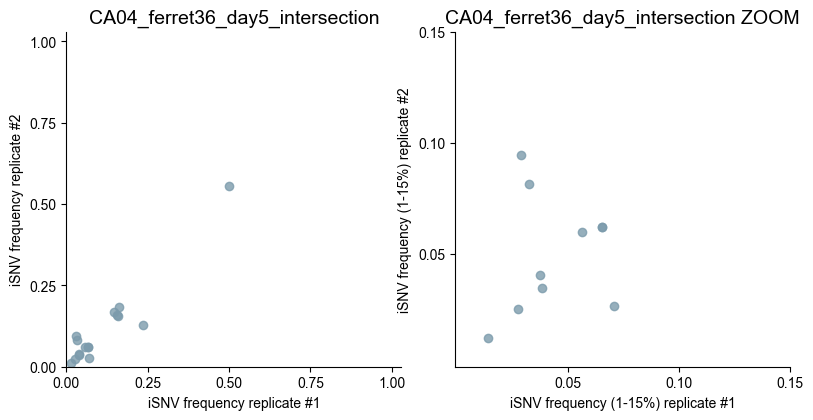

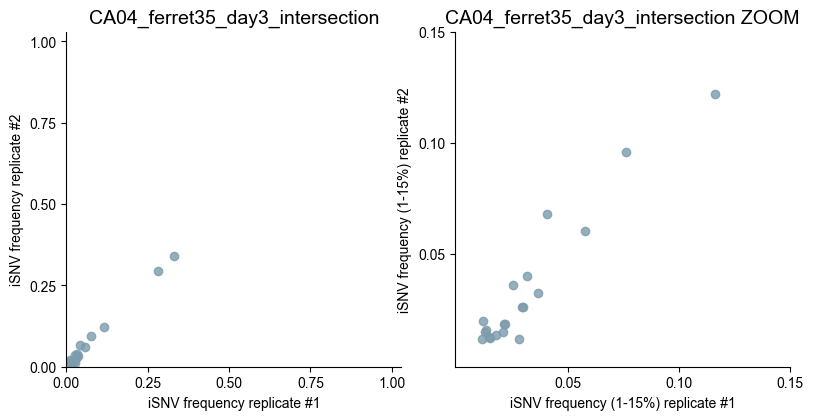

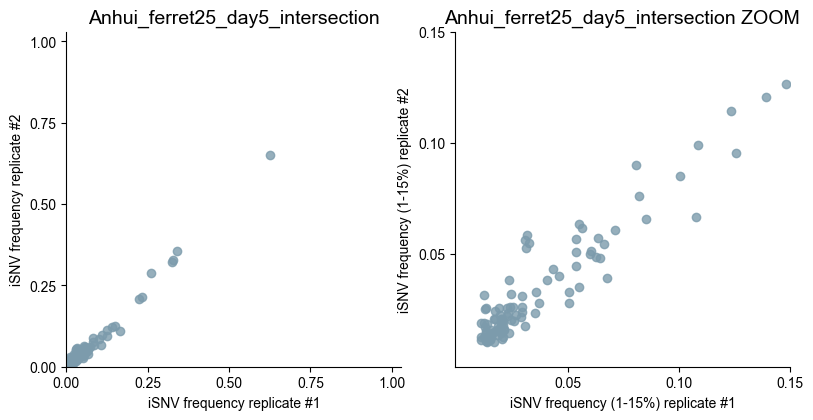

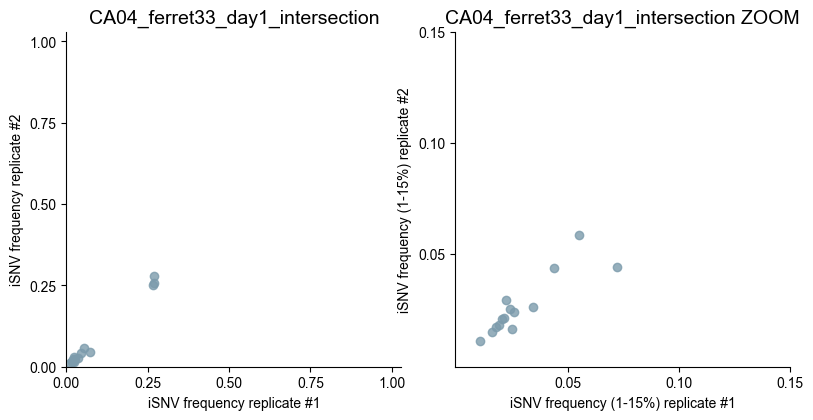

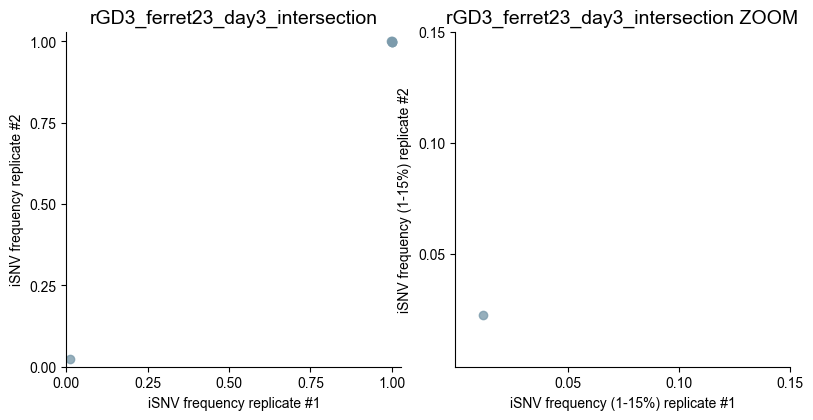

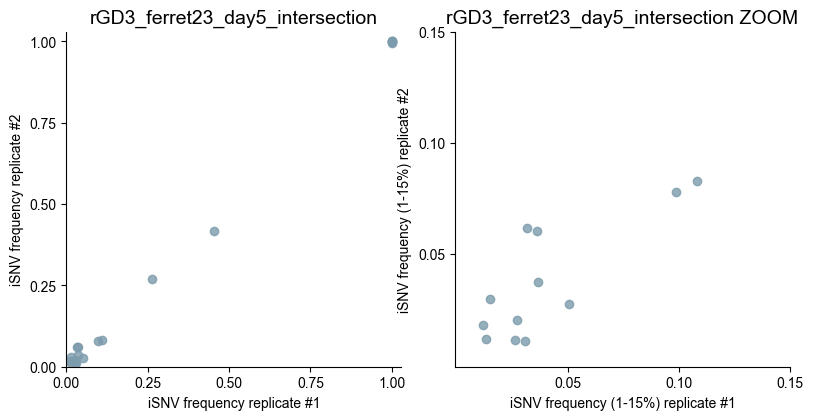

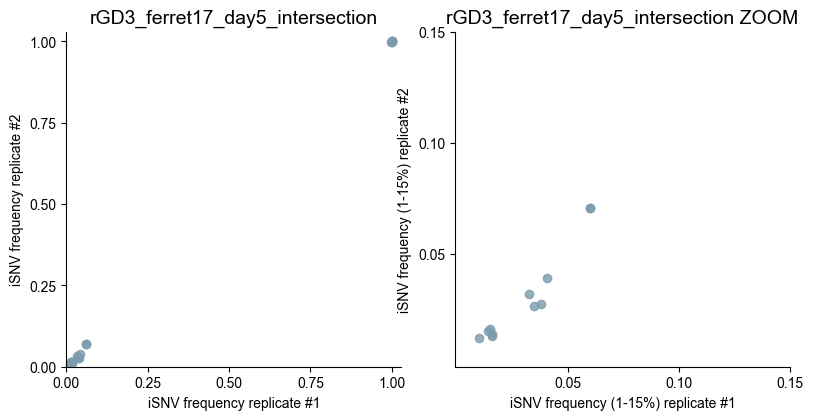

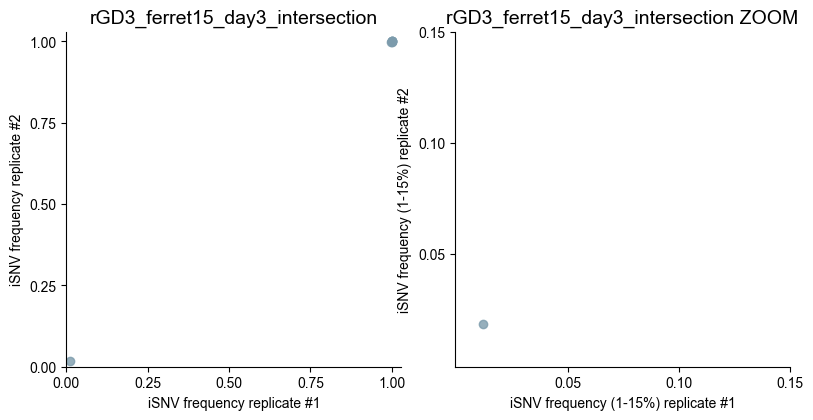

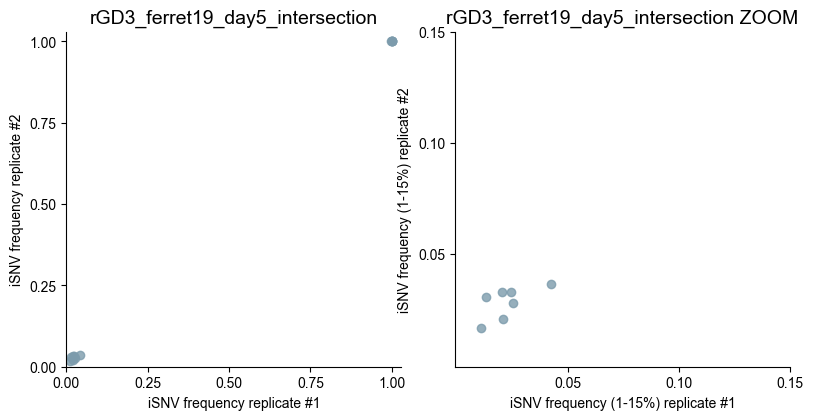

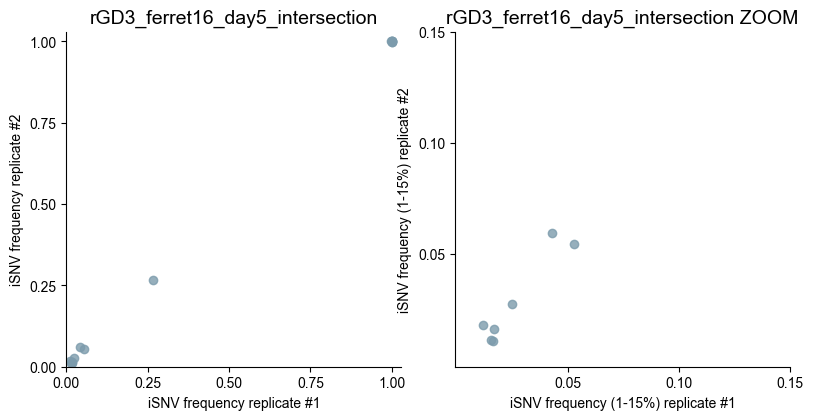

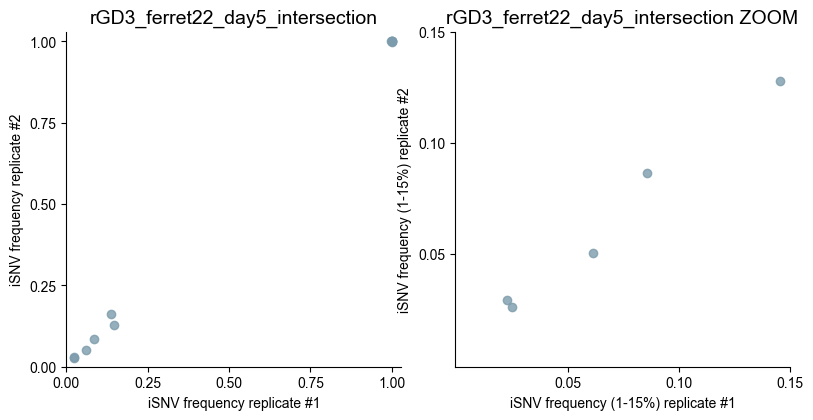

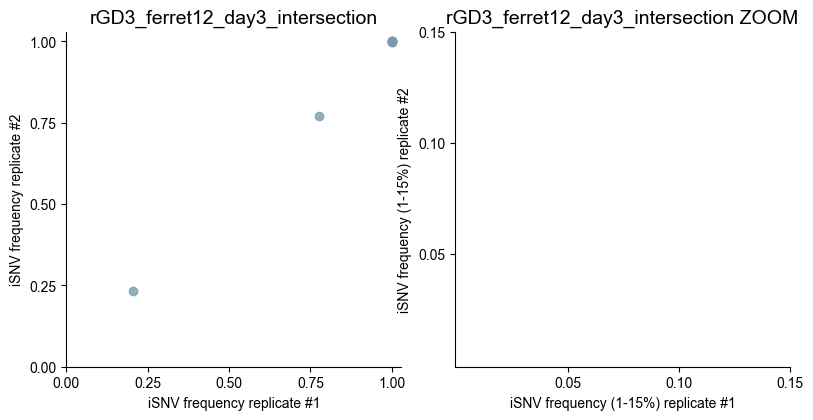

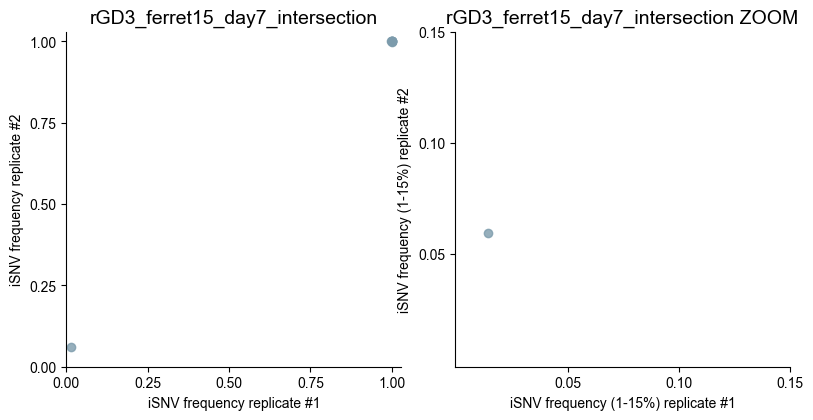

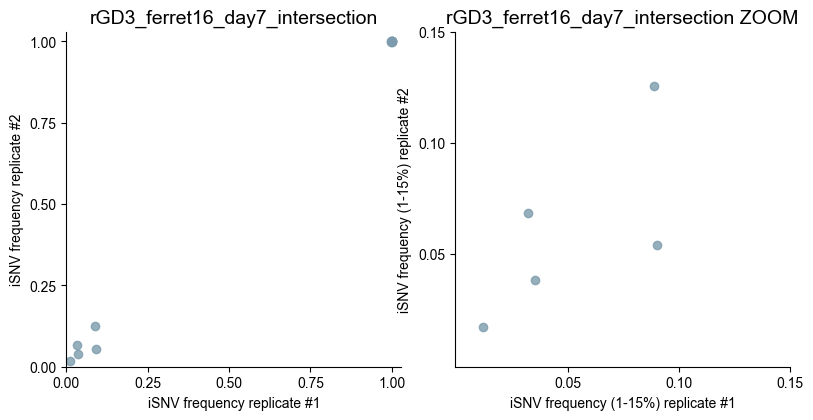

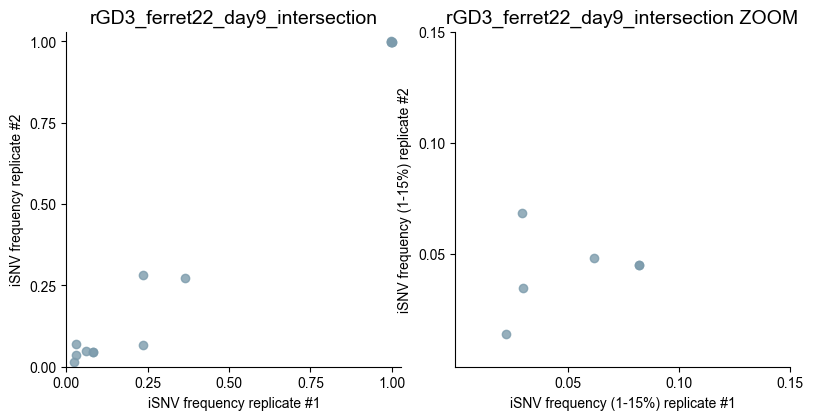

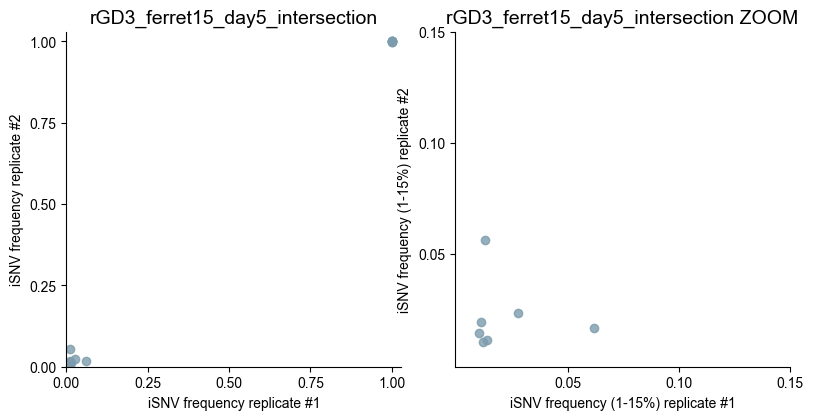

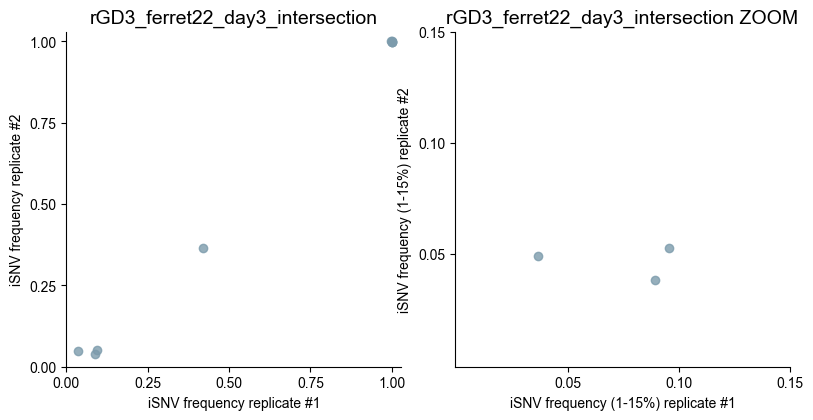

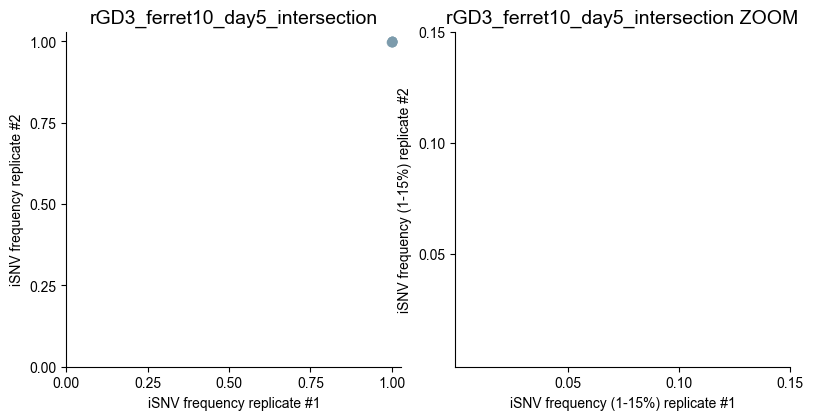

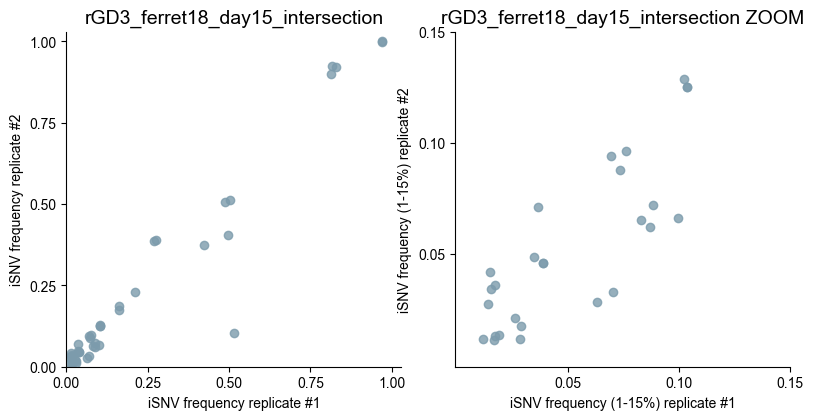

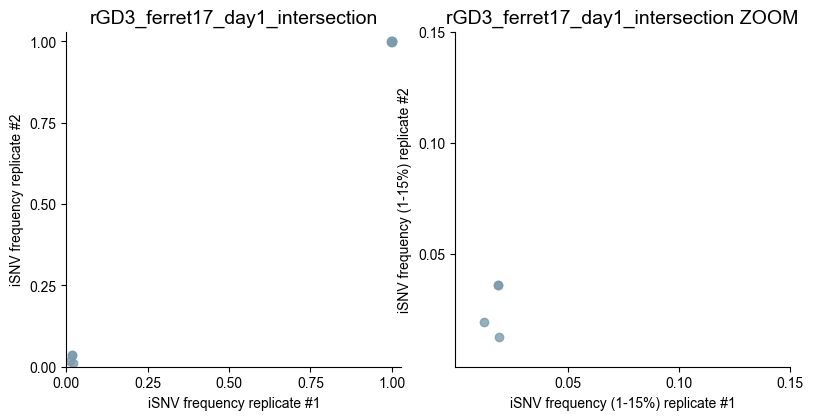

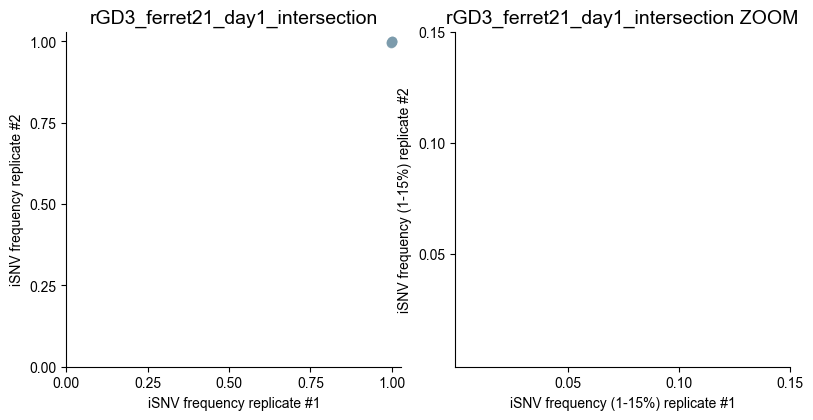

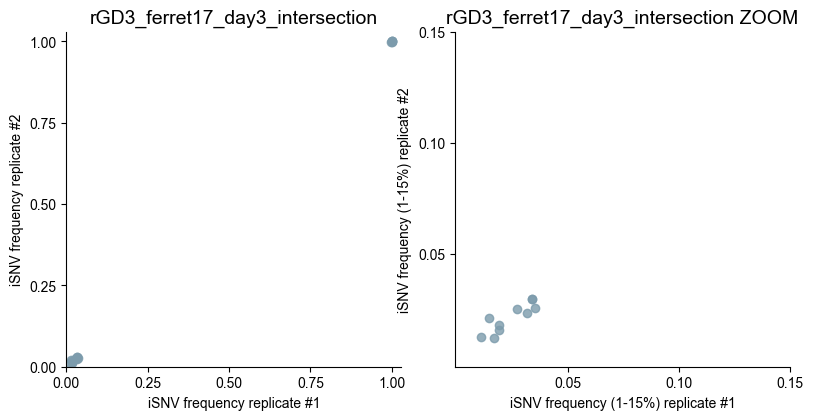

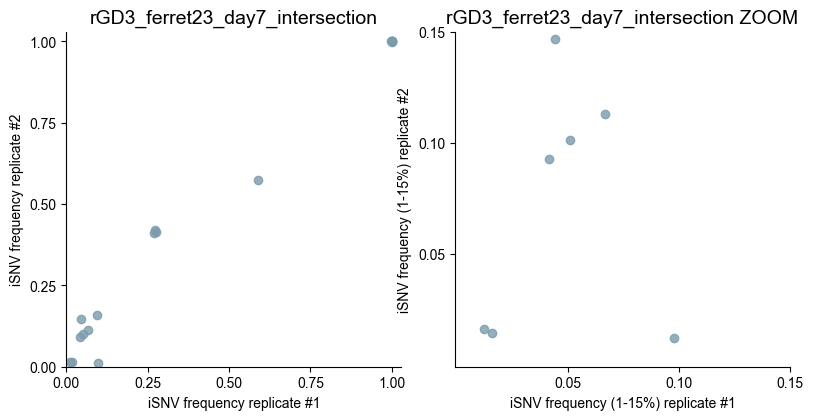

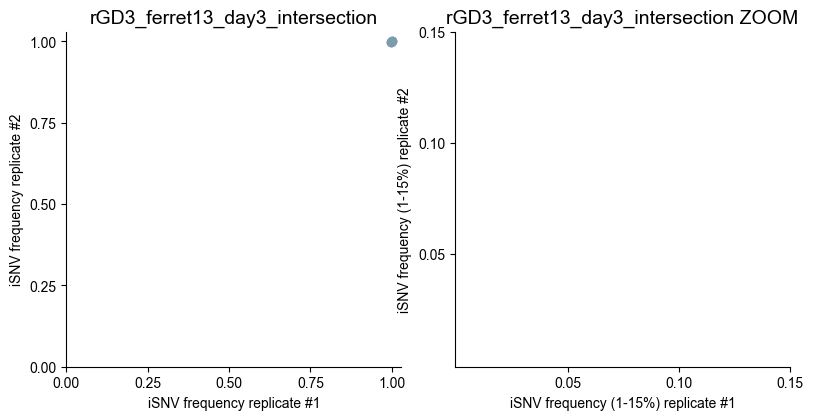

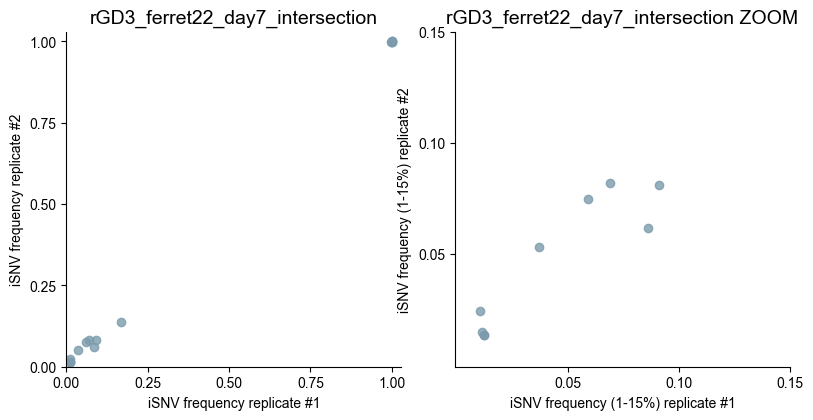

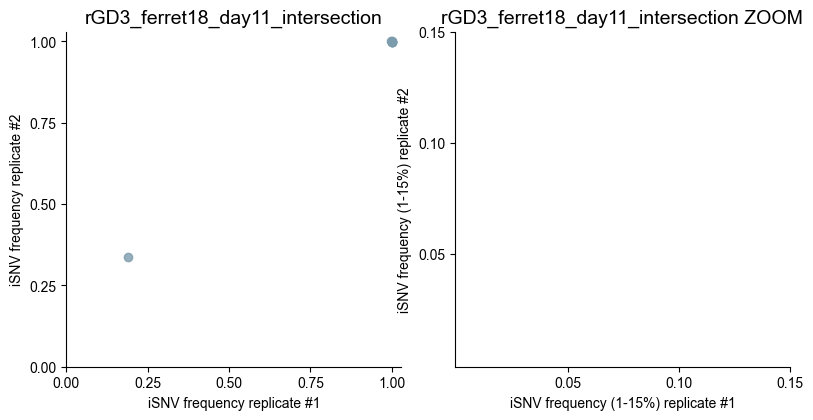

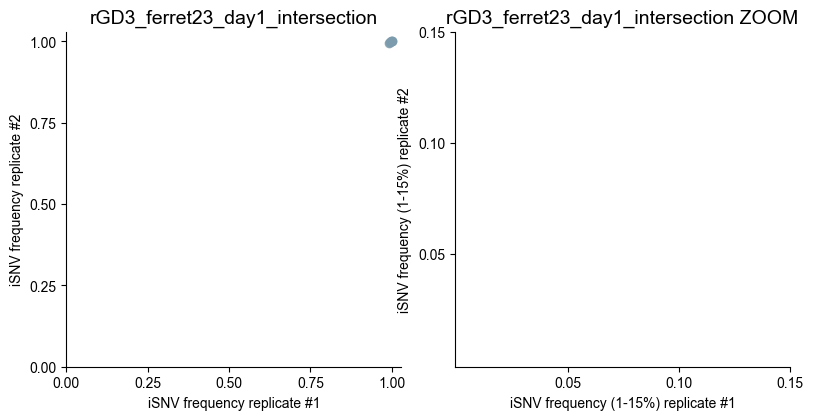

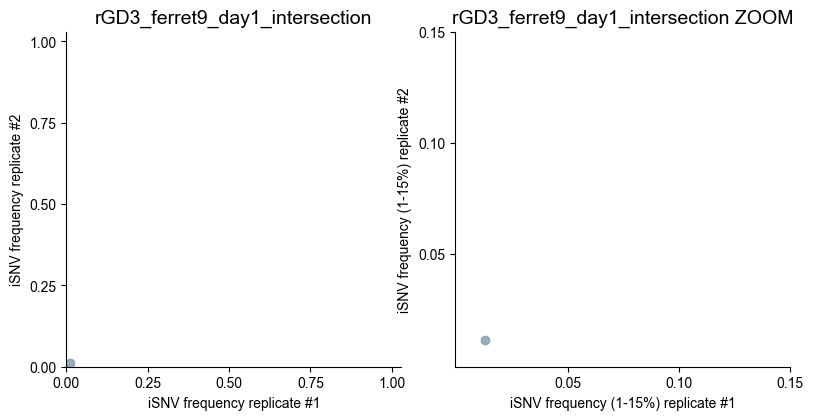

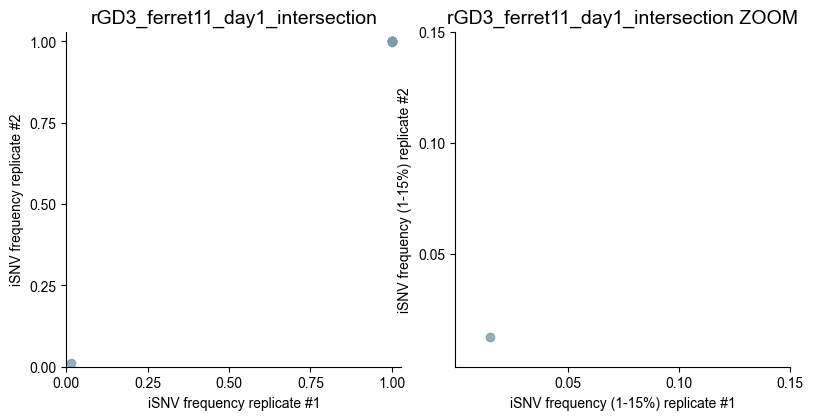

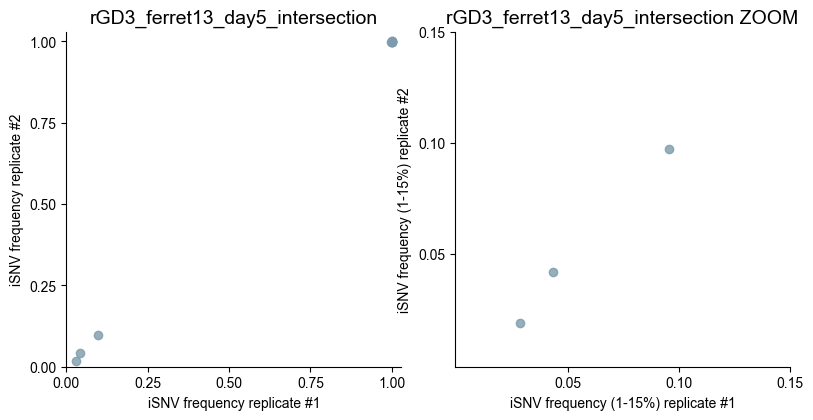

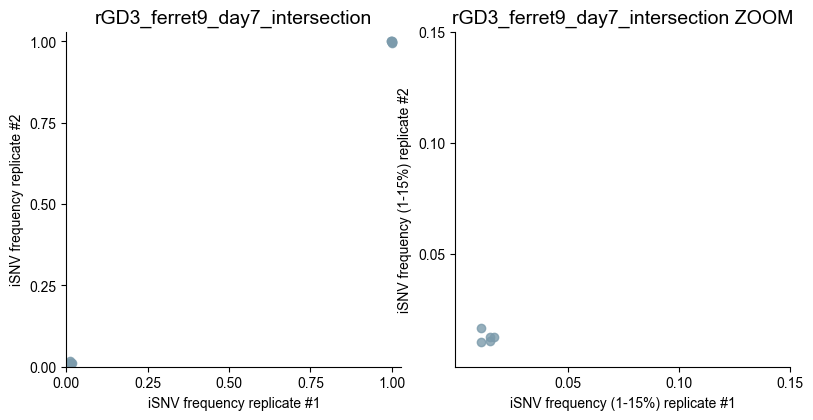

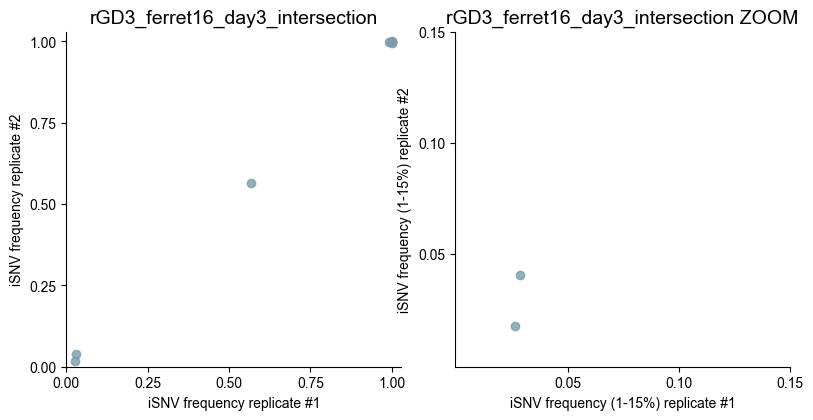

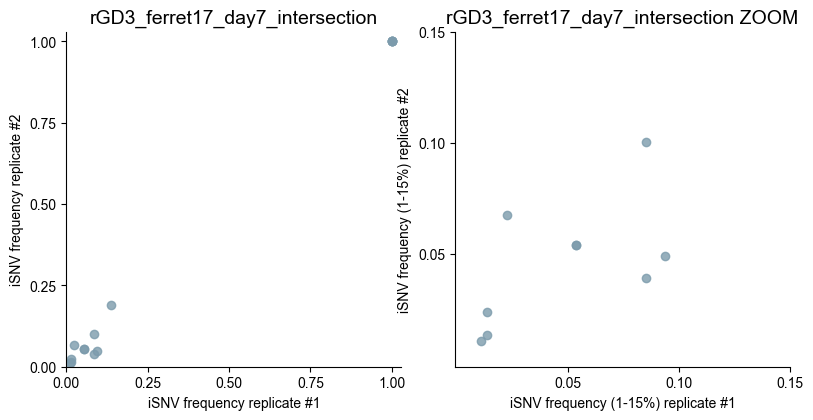

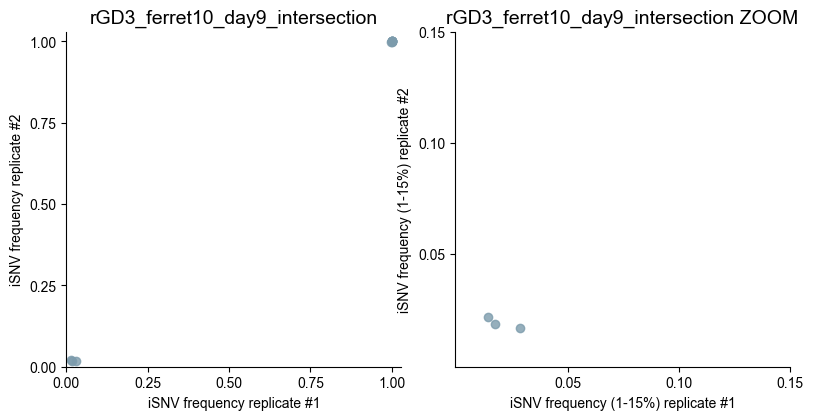

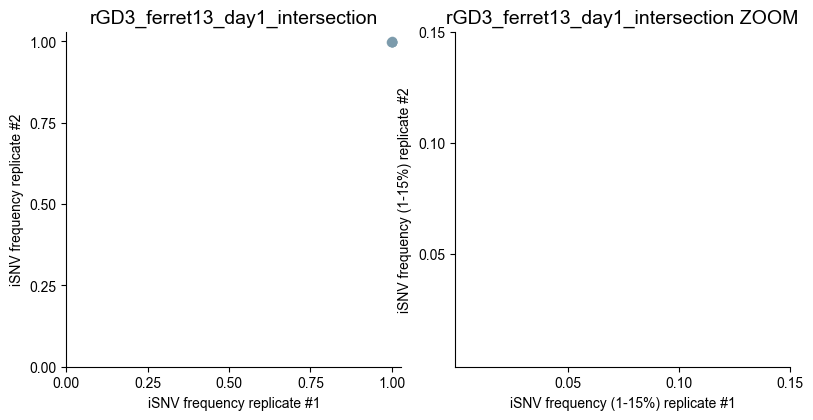

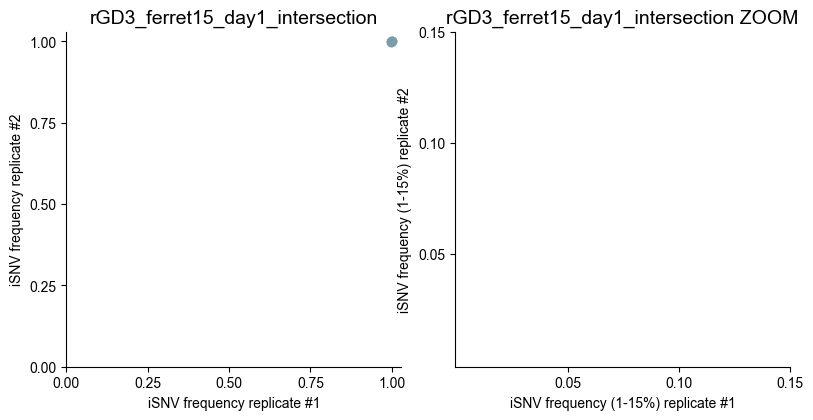

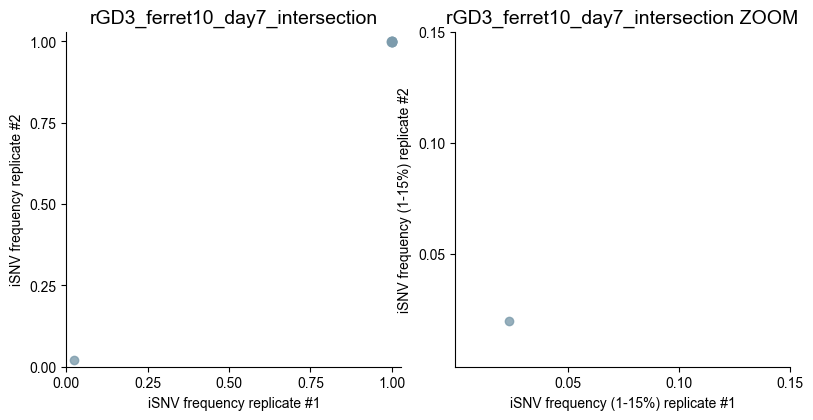

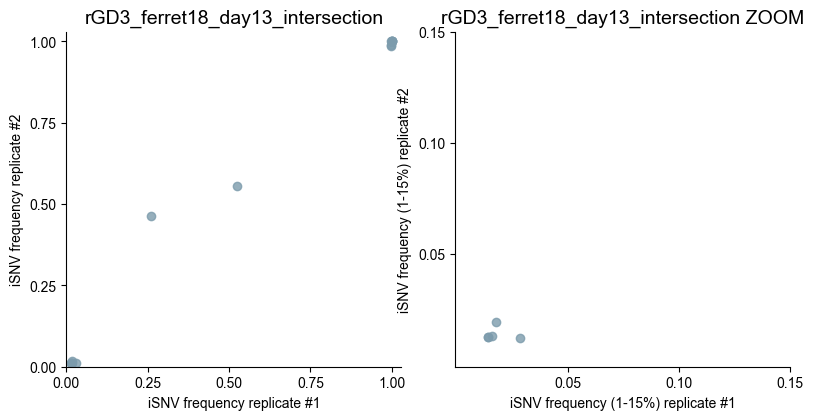

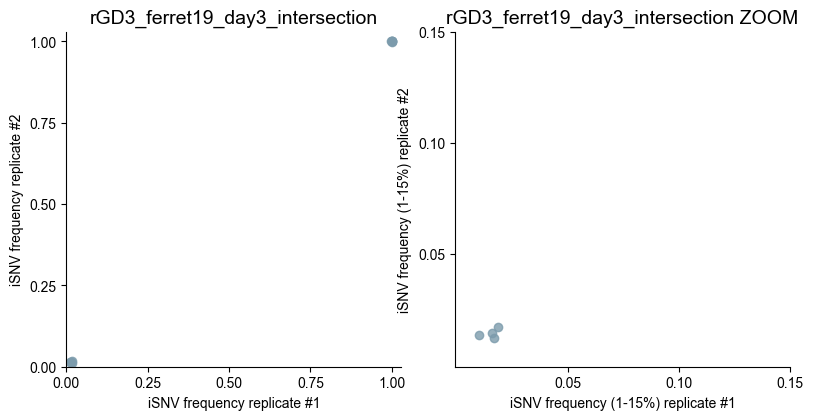

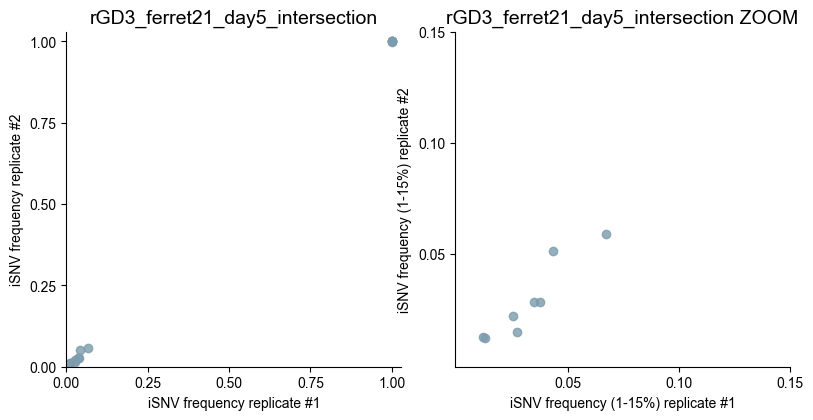

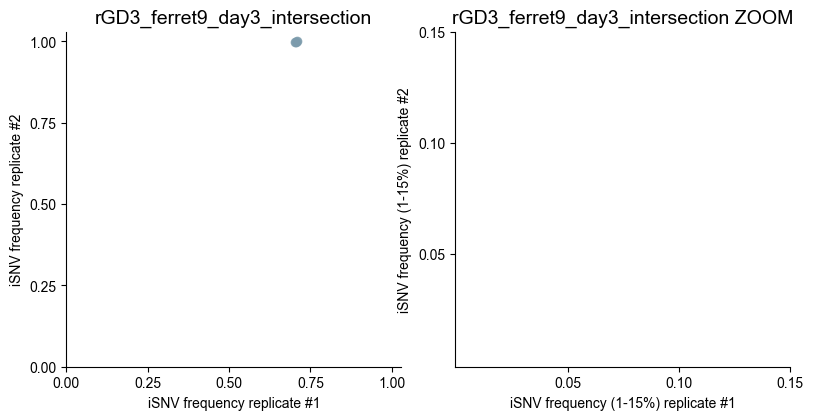

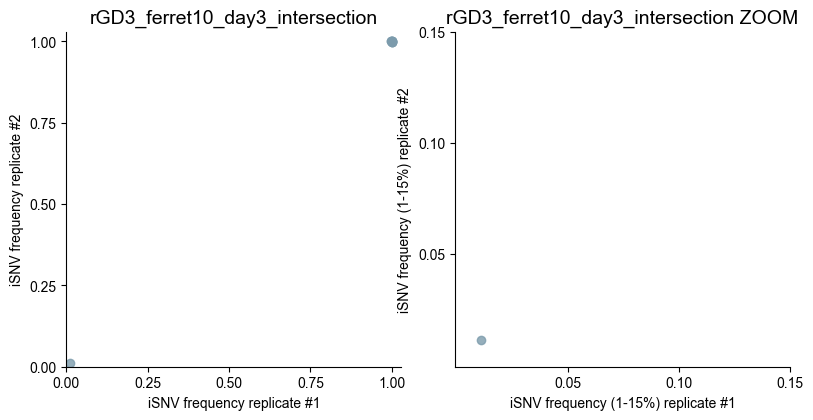

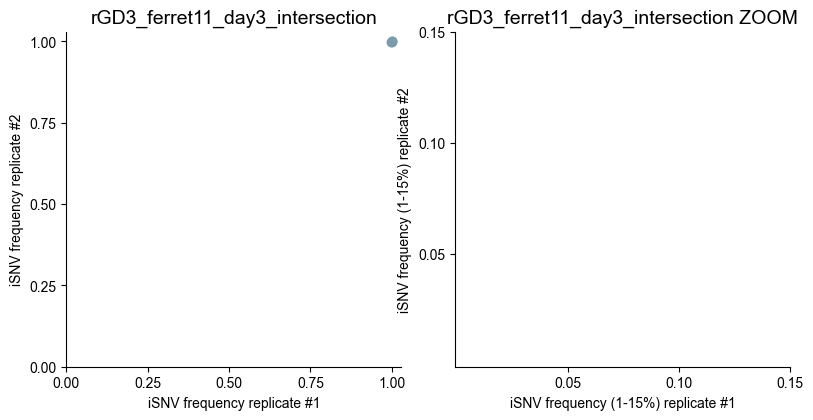

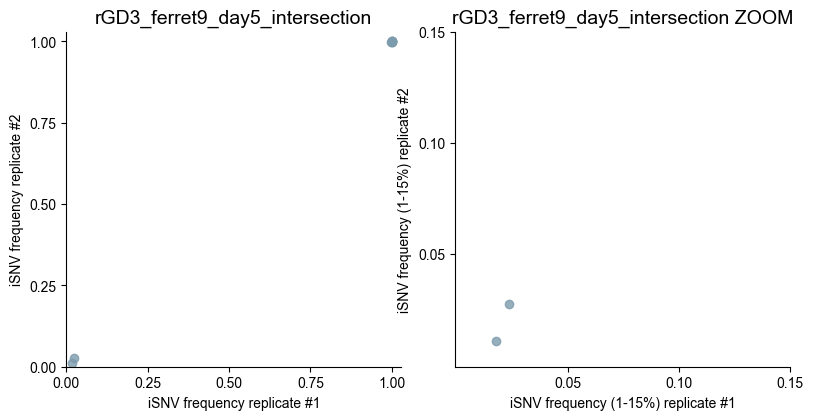

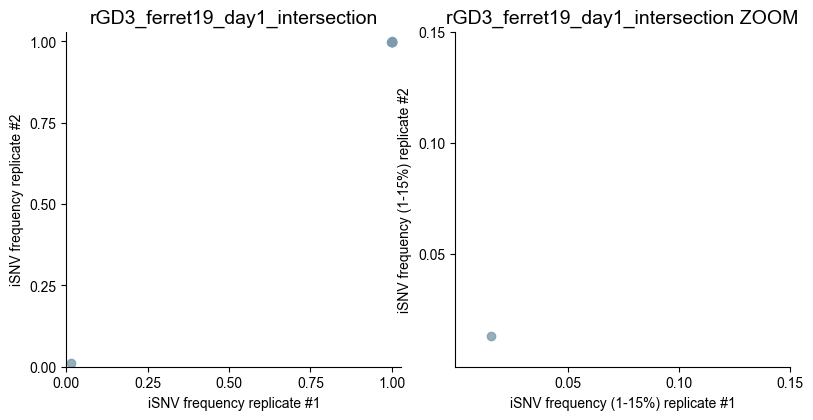

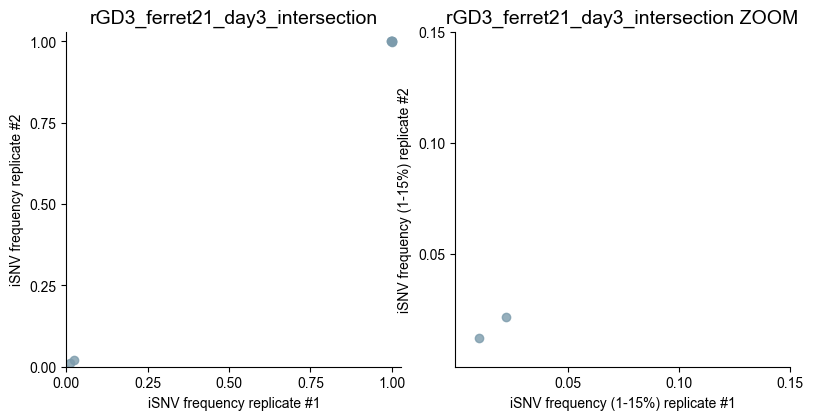

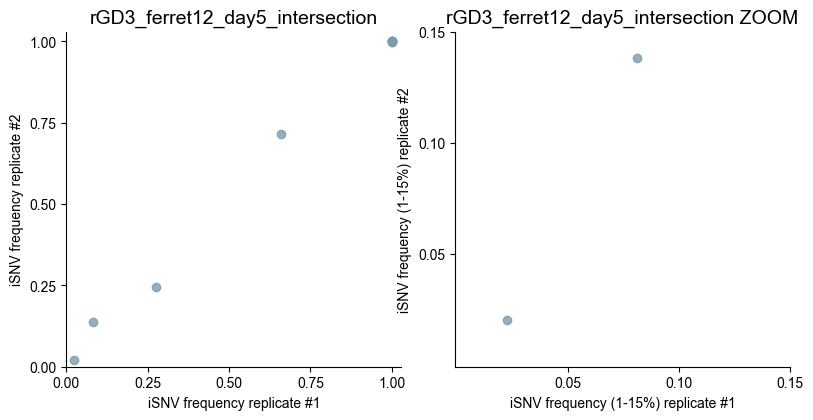

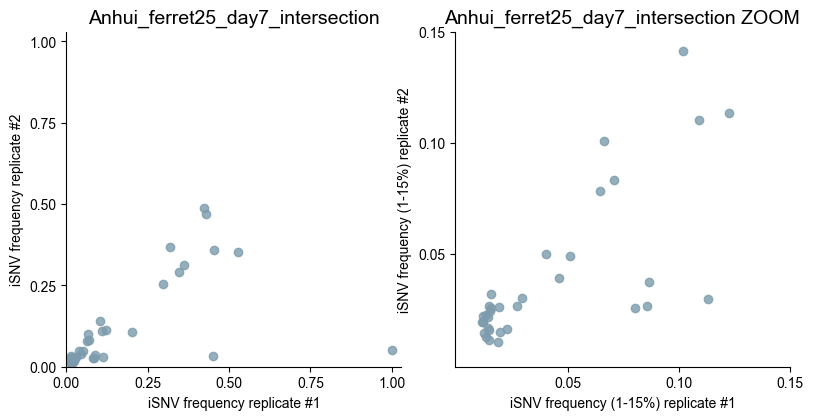

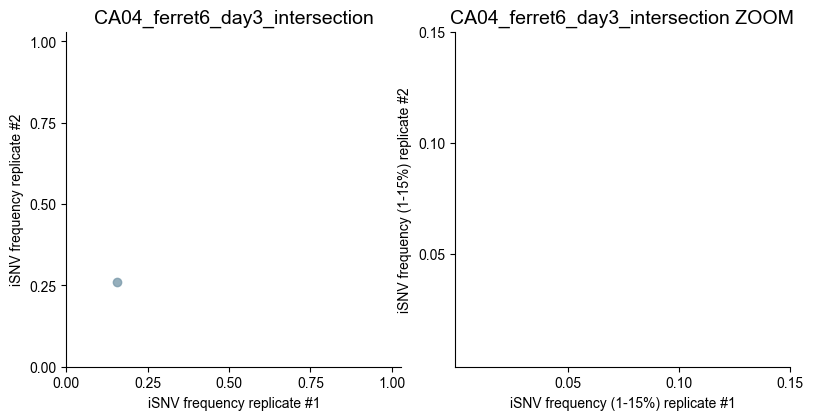

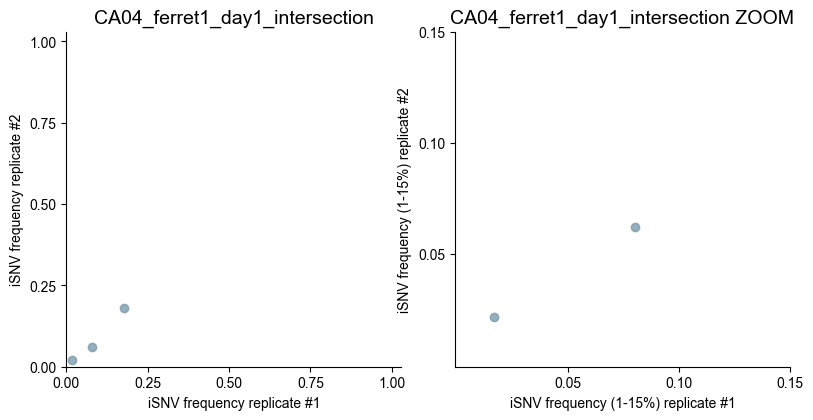

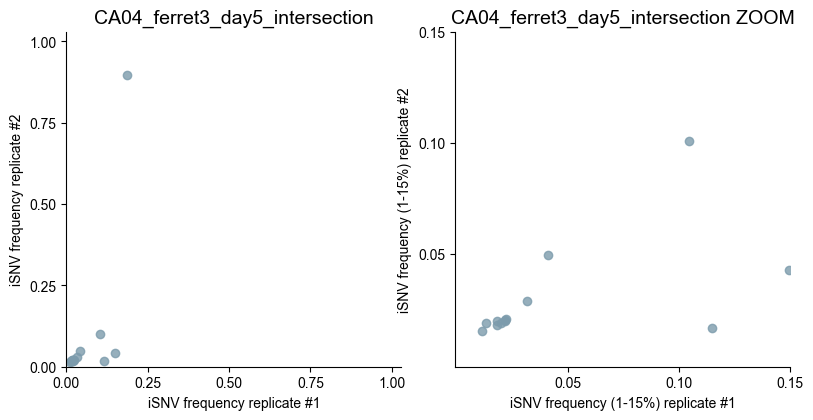

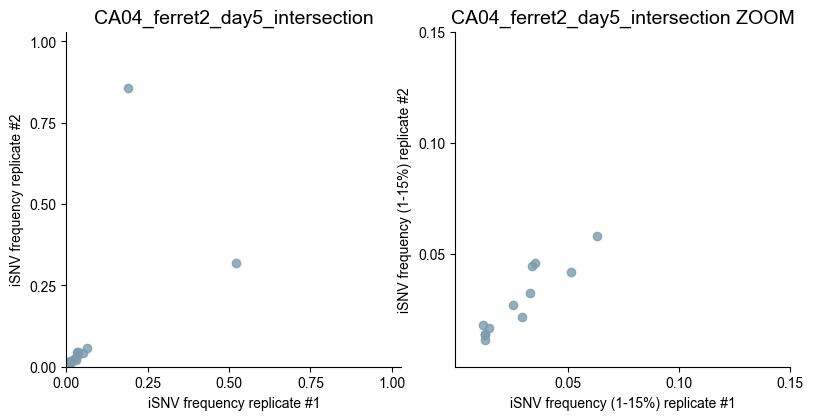

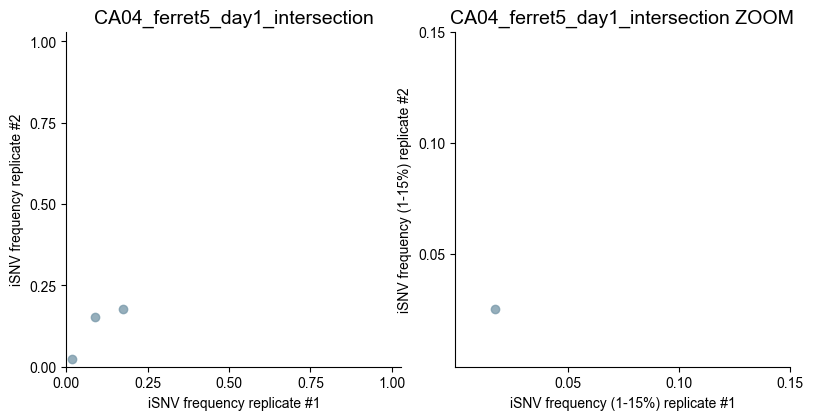

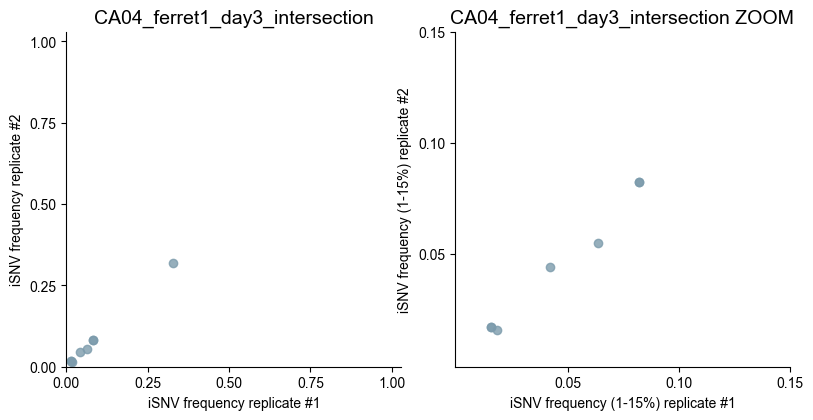

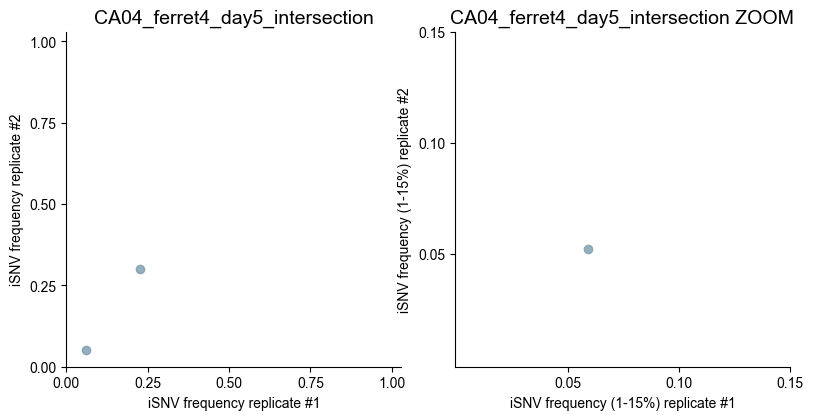

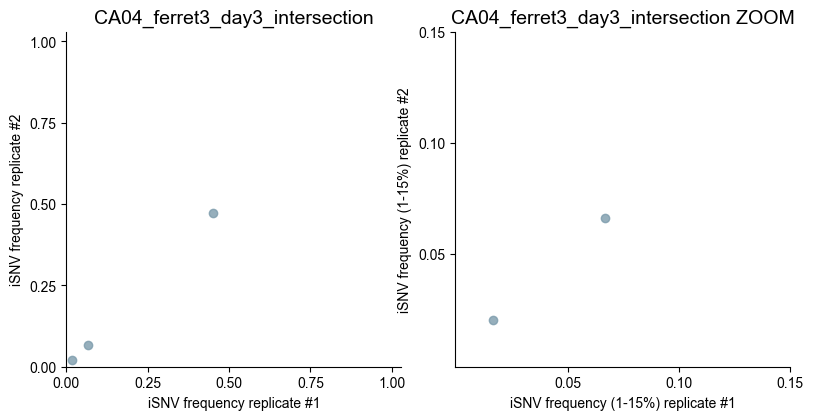

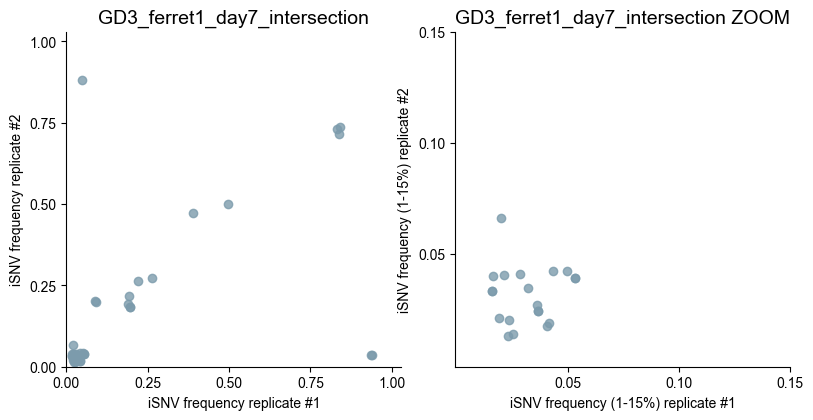

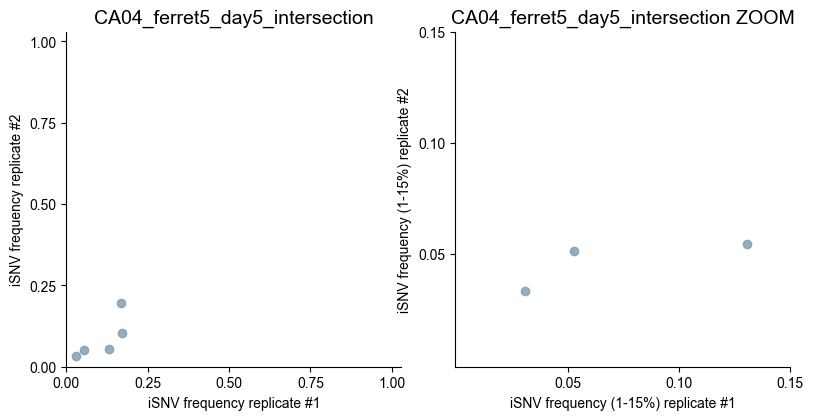

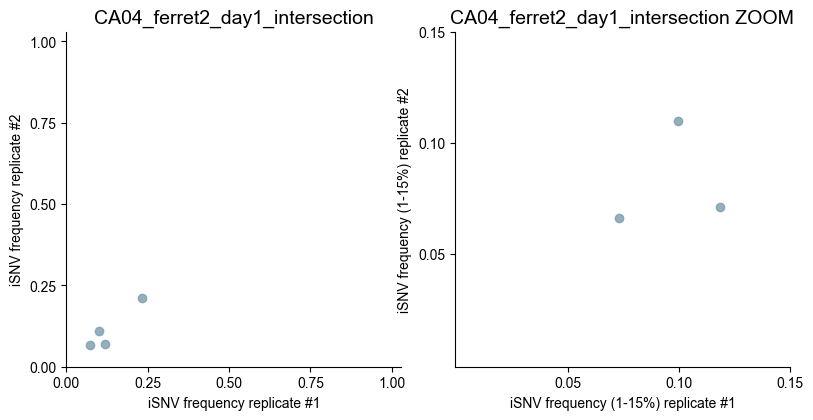

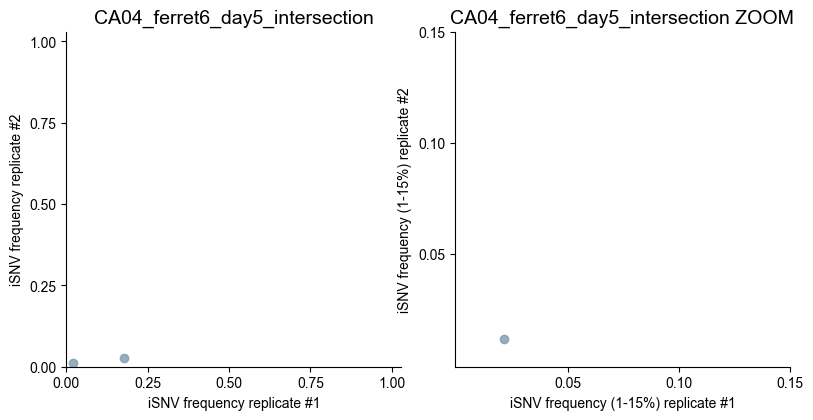

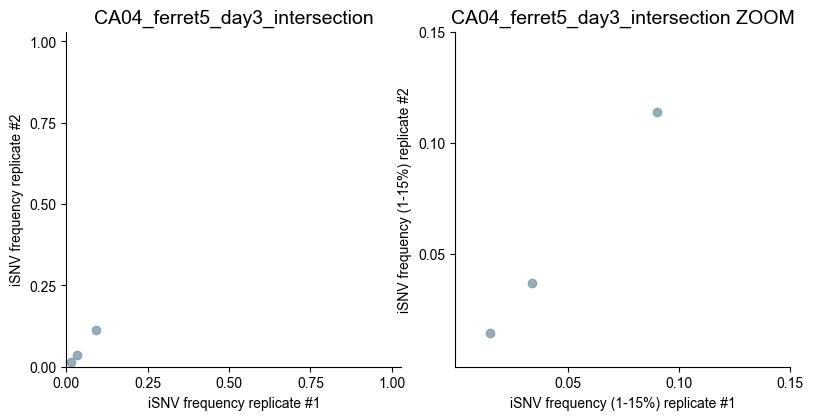

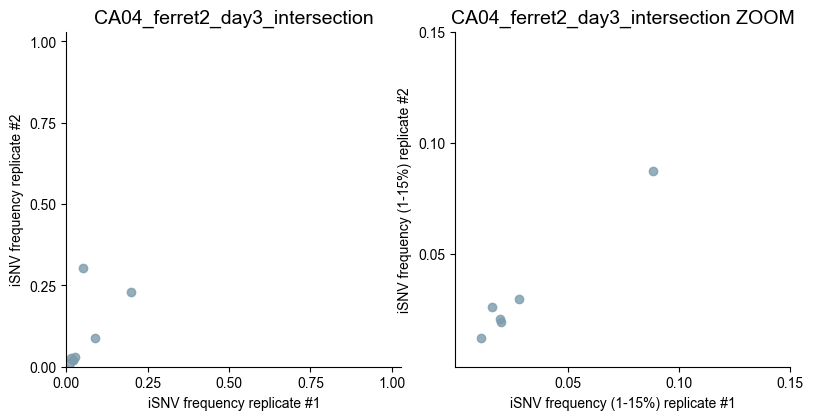

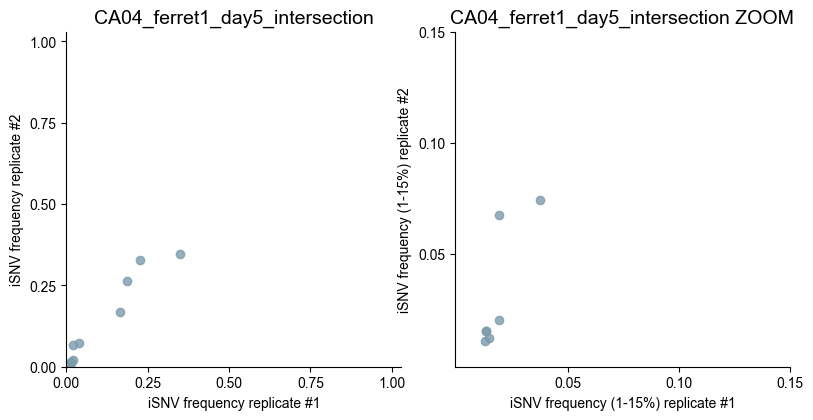

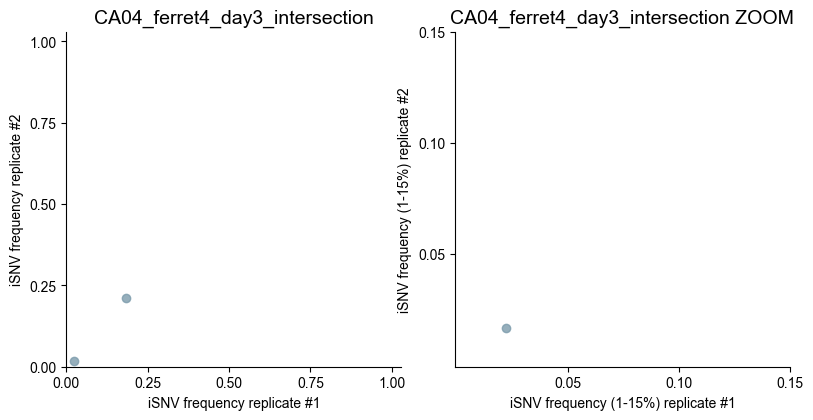

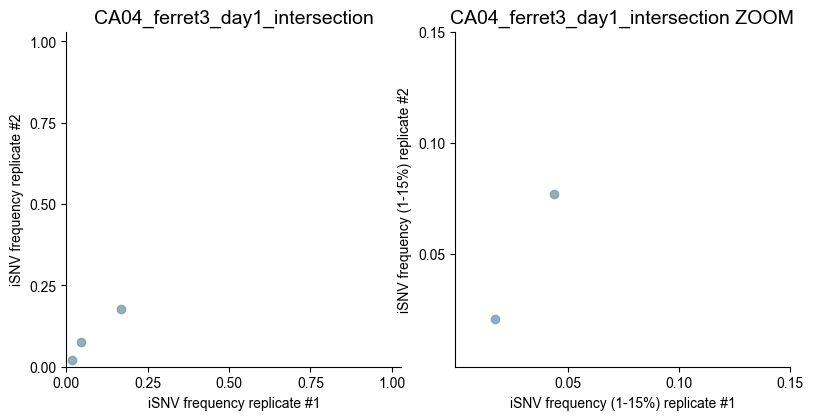

In [14]:
#list of intersection DFs
intersection_list = load_intersection_dataframes('../data_derived/vcfs-intersection')

#plot rep1 against rep2
plot_intersection(intersection_list)

In [15]:
%%bash

rm '../data_derived/vcfs-intersection/GD3_ferret1_day7_intersection.csv'
rm '../data_derived/vcfs-intersection/Anhui_ferret25_day7_intersection.csv'

In [16]:
#list of intersection DFs (after dropping two samples with consensus differences between replicates)
intersection_list = load_intersection_dataframes('../data_derived/vcfs-intersection')

# concatenate all dataframes in the list_of_intersectoin_DFs into a single DF 

DF_1percent = pd.concat(intersection_list)

#

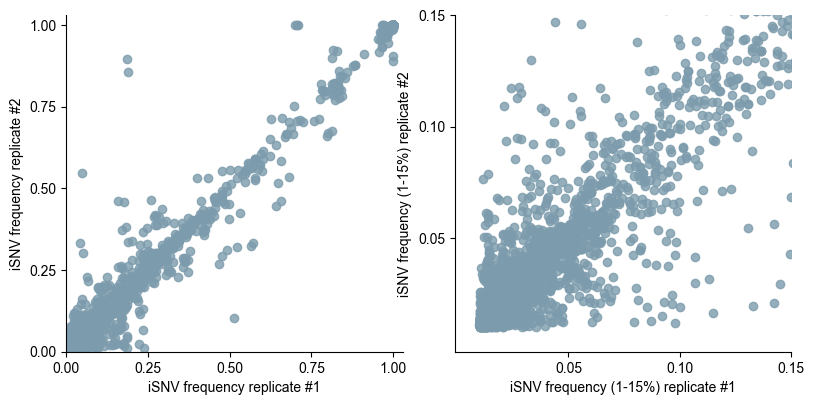

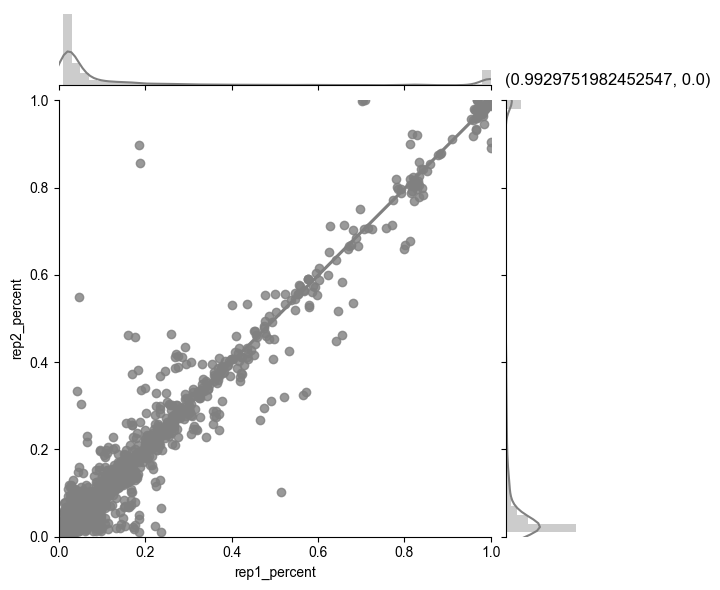

In [17]:
# plot intersections on a single plot to calculate linear correlation (I'd like to repeat this with multiple different frequency cut-offs)

plot_intersection_combined(intersection_list, DF_1percent)


#